## Andrew Byrnes: Fetch Rewards Coding Exercise - Data Analyst
### 1-Data_Prep.ipynb

This notebook preps the provided data files and uploads them to a SQLite database. It includes a an entity relationship diagram of the how I've modeled this data.
I chose SQLite for this challenge because it is lightweight and lends itself well to sharing.  
SQLite's flexible typing rules could be a liability for a database that would be continually updated and primarily used for analysis. For that usecase I would choose something that more strictly follows SQL standard.

### Data Sources
- data-modeling.html : coding exercise instuctions
- brands.json.gz, receipts.json.gz, users.json.gz : raw data files provided for completition of the challenge

### Changes
- 09-17-2022 : Started project, first look at data, identified transformation tasks 
- 09-18-2022 : cleaned df_brands _id and cpg columns
- 09-19-2022 : wrote function to clean columns with dicts, wrote function to convert epoch time to timestamps
- 09-20-2022 : refactored functions, applied funtions cleaning and converting data, explored df_receipts.rewardsReceiptItemList, notes on stakeholder questions
- 09-21-2022 : brainstorming notes on receipt_items, created df_receipt_items dataframe, loaded all 4 dataframes to SQLite fetch.db, drew fetch.db ERD
- 09-22-2022 : added a dupe_barcodes column to the brands data and reloaded, restarted kernal and re-ran everything
- 09-24-2022 : adjusting receipt_items ETL to bring in brandcode, regex to extract brandcodes, add extracted_brand_code to receipt_items

In [171]:
import pandas as pd
from pathlib import Path
import os
from datetime import datetime
import gzip
import json
import sqlite3
import re

### File Locations

In [172]:
today = datetime.today()
print(today)
in_brands = Path.cwd() / "data" / "raw" / "brands.json.gz"
in_receipts = Path.cwd() / "data" / "raw" / "receipts.json.gz"
in_users = Path.cwd() / "data" / "raw" / "users.json.gz"
db_path = Path.cwd() / "data" / "processed" / "fetch.db"

2022-09-24 12:02:36.547964


### Drop database if exists

In [173]:
if os.path.exists(db_path):
    os.remove(db_path)
    print("The db has been removed successfully")
else:
    print("The db does not exist!")

The db has been removed successfully


### Formatting and options

In [174]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')
# surpressing a warning related to renaming columns just prior to loading to sqlite
pd.options.mode.chained_assignment = None

### Load JSON data to Panda's dataframes

In [175]:
df_brands = pd.read_json(in_brands,lines=True,compression='gzip')
df_receipts = pd.read_json(in_receipts,lines=True,compression='gzip')
df_users = pd.read_json(in_users,lines=True,compression='gzip')

### First look at data

### **brands**  
**to-do**:
- ~extract _ids~
- ~extract cpg ids~

In [176]:
df_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   barcode       1167 non-null   int64  
 2   category      1012 non-null   object 
 3   categoryCode  517 non-null    object 
 4   cpg           1167 non-null   object 
 5   name          1167 non-null   object 
 6   topBrand      555 non-null    float64
 7   brandCode     933 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 73.1+ KB


**Brand Data Schema**
- _id: brand uuid
- barcode: the barcode on the item
- brandCode: String that corresponds with the brand column in a partner product file
- category: The category name for which the brand sells products in
- categoryCode: The category code that references a BrandCategory
- cpg: reference to CPG collection
- topBrand: Boolean indicator for whether the brand should be featured as a 'top brand'
- name: Brand name

In [177]:
df_brands

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...
1162,{'$oid': '5f77274dbe37ce6b592e90c0'},511111116752,Baking,BAKING,"{'$ref': 'Cogs', '$id': {'$oid': '5f77274dbe37ce6b592e90bf'}}",test brand @1601644365844,NaN,NaN
1163,{'$oid': '5dc1fca91dda2c0ad7da64ae'},511111706328,Breakfast & Cereal,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '53e10d6368abd3c7065097cc'}}",Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,{'$oid': '5f494c6e04db711dd8fe87e7'},511111416173,Candy & Sweets,CANDY_AND_SWEETS,"{'$ref': 'Cogs', '$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}}",test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,{'$oid': '5a021611e4b00efe02b02a57'},511111400608,Grocery,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5332f5f6e4b03c9a25efd0b4'}}",LIPTON TEA Leaves,0.0,LIPTON TEA Leaves


### **receipts**  
**to-do**:
- ~extract _ids~
- ~extract and convert createDate~
- ~extract and convert dateScanned~
- ~extract and convert finishedDate~
- ~extract and convert modifyDate~
- ~extract and convert pointsAwardedDate~
- ~extract and convert purchaseDate~
- create receipt_items table using the rewardsReceiptItemList

In [178]:
df_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    float64
 14  userId                  

**Receipts Data Schema**
- _id: uuid for this receipt
- bonusPointsEarned: Number of bonus points that were awarded upon receipt completion
- bonusPointsEarnedReason: event that triggered bonus points
- createDate: The date that the event was created
- dateScanned: Date that the user scanned their receipt
- finishedDate: Date that the receipt finished processing
- modifyDate: The date the event was modified
- pointsAwardedDate: The date we awarded points for the transaction
- pointsEarned: The number of points earned for the receipt
- purchaseDate: the date of the purchase
- purchasedItemCount: Count of number of items on the receipt
- rewardsReceiptItemList: The items that were purchased on the receipt
- rewardsReceiptStatus: status of the receipt through receipt validation and processing
- totalSpent: The total amount on the receipt
- userId: string id back to the User collection for the user who scanned the receipt

In [179]:
df_receipts

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,{'$oid': '603cc0630a720fde100003e6'},25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 16145

### **users**  
**to-do**:
- ~extract _ids~
- ~extract and convert createdDate~
- ~extract and convert lastLogin~

In [180]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           495 non-null    object
 1   active        495 non-null    bool  
 2   createdDate   495 non-null    object
 3   lastLogin     433 non-null    object
 4   role          495 non-null    object
 5   signUpSource  447 non-null    object
 6   state         439 non-null    object
dtypes: bool(1), object(6)
memory usage: 23.8+ KB


**Users Data Schema**
- _id: user Id
- state: state abbreviation
- createdDate: when the user created their account
- lastLogin: last time the user was recorded logging in to the app
- role: constant value set to 'CONSUMER'
- active: indicates if the user is active; only Fetch will de-activate an account with this flag

In [181]:
df_users

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
...,...,...,...,...,...,...,...
490,{'$oid': '54943462e4b07e684157a532'},True,{'$date': 1418998882381},{'$date': 1614963143204},fetch-staff,NaN,NaN
491,{'$oid': '54943462e4b07e684157a532'},True,{'$date': 1418998882381},{'$date': 1614963143204},fetch-staff,NaN,NaN
492,{'$oid': '54943462e4b07e684157a532'},True,{'$date': 1418998882381},{'$date': 1614963143204},fetch-staff,NaN,NaN
493,{'$oid': '54943462e4b07e684157a532'},True,{'$date': 1418998882381},{'$date': 1614963143204},fetch-staff,NaN,NaN


## Cleaning the data

### First attempt of extracting the values from columns containing dictionaries
I've chosen to include the following section of python code to help illustrate my thought process that lead to writting the value_from_dict() function. This code includes some notes as comments, but full explanation of my process is included within the documentation of the resulting function.  
The function should account for executing the following code, but if you are stepping through this notebook on a fresh kernel you can skip the cells between **Start** and **End**.

**Start** - you *can* skip executing the code starting here

In [182]:
# confirming the values in _id are being recoginized python objects, in this case a dictionary
type(df_brands['_id'][0])

dict

In [183]:
df_brands['_id'][0]['$oid']

'601ac115be37ce2ead437551'

In [184]:
# extract the _id column as a series
_id_series = df_brands['_id']
# create an list to collect the values from the dictionary objects in _id
_id_clean = []

# iterate through _id_series appending values them to _id_clean
for index, value in _id_series.items():
    _id_clean.append(value['$oid'])
    
# confirm no nulls in _id_clean
assert None not in _id_clean, "there is at least one None/null value in _id_clean"
# confirm _id_clean is the same length is the original _id column in df_brands
assert len(_id_clean) == len(df_brands['_id']), "the length of the original column and the cleaned column are not the same"

# add _id_clean to df_brands after the _id column
df_brands.insert(1, '_id_clean', _id_clean)

df_brands

,_id,_id_clean,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},601ac115be37ce2ead437551,511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},601ac142be37ce2ead43755d,511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},601ac142be37ce2ead43755a,511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...
1162,{'$oid': '5f77274dbe37ce6b592e90c0'},5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,"{'$ref': 'Cogs', '$id': {'$oid': '5f77274dbe37ce6b592e90bf'}}",test brand @1601644365844,NaN,NaN
1163,{'$oid': '5dc1fca91dda2c0ad7da64ae'},5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '53e10d6368abd3c7065097cc'}}",Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,{'$oid': '5f494c6e04db711dd8fe87e7'},5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,"{'$ref': 'Cogs', '$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}}",test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,{'$oid': '5a021611e4b00efe02b02a57'},5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5332f5f6e4b03c9a25efd0b4'}}",LIPTON TEA Leaves,0.0,LIPTON TEA Leaves


In [185]:
# examining the values in cpg
type(df_brands['cpg'])

pandas.core.series.Series

In [186]:
df_brands['cpg'][0]

{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}

In [187]:
df_brands['cpg'][0]['$id']['$oid']

'601ac114be37ce2ead437550'

In [188]:
# extract the cpg column as a series
cpg_series = df_brands['cpg']
# create an list to collect the values from the dictionary objects in _id
cpg_clean = []

# iterate through cpg_series appending values them to cpg_clean
for index, value in cpg_series.items():
    cpg_clean.append(value['$id']['$oid'])
    
# confirm no nulls in _id_clean
assert None not in cpg_clean, "there is at least one None/null value in cpg_clean"
# confirm cpg_clean is the same length is the original cpg column in df_brands
assert len(cpg_clean) == len(df_brands['cpg']), "the length of the original column and the cleaned column are not the same"

# add cpg_clean to df_brands after the cpg column
df_brands.insert(6, 'cpg_clean', cpg_clean)

df_brands

,_id,_id_clean,barcode,category,categoryCode,cpg,cpg_clean,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},601ac115be37ce2ead437551,511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",601ac114be37ce2ead437550,test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",5332f5fbe4b03c9a25efd0ba,Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},601ac142be37ce2ead43755d,511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",601ac142be37ce2ead437559,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},601ac142be37ce2ead43755a,511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",601ac142be37ce2ead437559,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",5332fa12e4b03c9a25efd1e7,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...,...
1162,{'$oid': '5f77274dbe37ce6b592e90c0'},5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,"{'$ref': 'Cogs', '$id': {'$oid': '5f77274dbe37ce6b592e90bf'}}",5f77274dbe37ce6b592e90bf,test brand @1601644365844,NaN,NaN
1163,{'$oid': '5dc1fca91dda2c0ad7da64ae'},5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '53e10d6368abd3c7065097cc'}}",53e10d6368abd3c7065097cc,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,{'$oid': '5f494c6e04db711dd8fe87e7'},5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,"{'$ref': 'Cogs', '$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}}",5332fa12e4b03c9a25efd1e7,test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,{'$oid': '5a021611e4b00efe02b02a57'},5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5332f5f6e4b03c9a25efd0b4'}}",5332f5f6e4b03c9a25efd0b4,LIPTON TEA Leaves,0.0,LIPTON TEA Leaves


In [189]:
dataframe = df_brands
column_to_clean ='cpg'
dirty_series = dataframe[column_to_clean]
dirty_series
insert_at = dataframe.columns.get_loc(column_to_clean) + 1
cleaned_list = []
dict_key = "['$id']['$oid']"
dict_key_value = "value" + dict_key


for index, value in dirty_series.items():
    cleaned_list.append(eval(dict_key_value))

cleaned_list



['601ac114be37ce2ead437550',
 '5332f5fbe4b03c9a25efd0ba',
 '601ac142be37ce2ead437559',
 '601ac142be37ce2ead437559',
 '5332fa12e4b03c9a25efd1e7',
 '601ac142be37ce2ead437559',
 '601ac142be37ce2ead437559',
 '559c2234e4b06aca36af13c6',
 '5a734034e4b0d58f376be874',
 '59ba6f1ce4b092b29c167346',
 '5f4bf556be37ce0b44915549',
 '5332f5f2e4b03c9a25efd0aa',
 '559c2234e4b06aca36af13c6',
 '5d5d4fd16d5f3b23d1bc7905',
 '5332f5fbe4b03c9a25efd0ba',
 '5332f709e4b03c9a25efd0f1',
 '5d9b4f591dda2c6225a284aa',
 '5f358338be37ce443bf9d557',
 '5fb28549be37ce522e165cb4',
 '5332f5f6e4b03c9a25efd0b4',
 '55b62995e4b0d8e685c14213',
 '5d9b4f591dda2c6225a284aa',
 '559c2234e4b06aca36af13c6',
 '53e10d6368abd3c7065097cc',
 '5332f5ebe4b03c9a25efd0a8',
 '5e9f12f5be37ce3e45b6a77e',
 '5332f5f6e4b03c9a25efd0b4',
 '5d5d4fd16d5f3b23d1bc7905',
 '5f493e72be37ce64d0ae36c2',
 '5f4936dcbe37ce52f8314fd8',
 '559c2234e4b06aca36af13c6',
 '5fd2a0aebe37ce49eb72c0ed',
 '53e10d6368abd3c7065097cc',
 '5f494c5d04db711dd8fe87e2',
 '5332f5f3e4b0

In [190]:
dataframe

,_id,_id_clean,barcode,category,categoryCode,cpg,cpg_clean,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},601ac115be37ce2ead437551,511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",601ac114be37ce2ead437550,test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",5332f5fbe4b03c9a25efd0ba,Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},601ac142be37ce2ead43755d,511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",601ac142be37ce2ead437559,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},601ac142be37ce2ead43755a,511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",601ac142be37ce2ead437559,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",5332fa12e4b03c9a25efd1e7,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...,...
1162,{'$oid': '5f77274dbe37ce6b592e90c0'},5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,"{'$ref': 'Cogs', '$id': {'$oid': '5f77274dbe37ce6b592e90bf'}}",5f77274dbe37ce6b592e90bf,test brand @1601644365844,NaN,NaN
1163,{'$oid': '5dc1fca91dda2c0ad7da64ae'},5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '53e10d6368abd3c7065097cc'}}",53e10d6368abd3c7065097cc,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,{'$oid': '5f494c6e04db711dd8fe87e7'},5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,"{'$ref': 'Cogs', '$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}}",5332fa12e4b03c9a25efd1e7,test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,{'$oid': '5a021611e4b00efe02b02a57'},5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5332f5f6e4b03c9a25efd0b4'}}",5332f5f6e4b03c9a25efd0b4,LIPTON TEA Leaves,0.0,LIPTON TEA Leaves


In [191]:
# reset df_brands to the inital load of raw data - if excuted above code, 
# uncomment the following line to avoid any exceptions with value_from_dict() 
df_brands = pd.read_json(in_brands,lines=True,compression='gzip')

**End** You can continue executing the following cells

### Writting a function to extract values from a dataframe's column that contains a dictionary. Then adds those values back to the dataframe as a new column.

In [192]:
# I realized I'd be doing this multiple times, better to make a function
# define a function that cleans a df column that contains a dictionary by returning the specified 
# values and adding them as new column in the dataframe
def value_from_dict(dataframe, column_to_clean, dict_key, allow_nulls = False):
    """Returns dataframe with a 'cleaned' column inserted after the column that was cleaned.
    
    :param dataframe: A dataframe with a column containing dictionaries, from which one value is
        to be extracted
    :type dataframe: Pandas DataFrame
    :param column_to_clean: The name of the column containing dictionaries
    :type column_to_clean: str
    :param dict_key: A str containing the key associated with the value we want to extract,
        e.g, "['$id']['$oid']"
    :type dict_key: str
    :param allow_nulls: A boolean value indicating if None/Null/NaN/NaT values should be allowed,
        defaults to False
    :type allow_nulls: bool
    
    :raises AssertionError: 'there is at least one None/Null/NaN/NaT value in the cleaned data' if param allow_nulls = False
    :raises AssertionError: 'the length of the original column and the cleaned column are not the same'
    :excepts VlueError: If a column has already been cleaned, print message confirming
        no values were added to the dataframe
    
    :rtype: Pandas DataFrame
    :return: the original DataFrame with an additional column containing 'cleaned' values
    """
    # setting variables:
    # extract the column we want to clean from the dataframe as a series
    dirty_series = dataframe[column_to_clean]
    # create a list to store the cleaned values in
    cleaned_list = []
    # name of the column we'll be adding to the DataFrame
    cleaned_column_name = column_to_clean + '_cleaned'
    # location to insert the cleaned column, after the 'dirty' column
    insert_at = dataframe.columns.get_loc(column_to_clean) + 1
    # translate dict_key str into a format useable in the following for loop
    value_dict_key = "value" + dict_key
    
    # iterate through dirty_series appending extracted values to cleaned_list
    for index, value in dirty_series.items():
        # if there is no dictionary or any other issue, append None
        try:
            cleaned_list.append(eval(value_dict_key))
        except:
            cleaned_list.append(None)

    # handle allow_nulls param flag
    if not allow_nulls:
        # confirm no nulls in cleaned_list
        assert None not in cleaned_list, "there is at least one None value in the cleaned data"
    
    # confirm cleaned_list is the same length as dirty_series
    assert len(cleaned_list) == len(dirty_series), "the length of the original column and the cleaned column are not the same"
    
    # add the cleaned_list data to the originl dataframe following column_to_clean
    try:
        dataframe.insert(insert_at, cleaned_column_name, cleaned_list)
    except ValueError as error:
        print(f"{str(error)}, {cleaned_column_name} was not added to the dataframe")

    # return the modified dataframe
    return dataframe

### Using  value_from_dict() to exatract values from all the columns containing dictionaries and add them to the dataframe as a new column:

#### df_brands._id :

In [193]:
# look at the first value in df_brands._id
df_brands['_id'][0]

{'$oid': '601ac115be37ce2ead437551'}

In [194]:
#extract the value
df_brands['_id'][0]['$oid']

'601ac115be37ce2ead437551'

In [195]:
# access the value, set a varbale to use for the dict_key param of value_from_dict() function
brand_id_dict_key = "['$oid']"

In [196]:
# clean df_brands._id and confirm by viewing a sample of the dataframe
value_from_dict(df_brands, "_id", brand_id_dict_key)
df_brands.sample(2)

,_id,_id_cleaned,barcode,category,categoryCode,cpg,name,topBrand,brandCode
965,{'$oid': '5332f5f5e4b03c9a25efd0b1'},5332f5f5e4b03c9a25efd0b1,511111203995,NaN,NaN,"{'$ref': 'Cpgs', '$id': {'$oid': '5332f5ebe4b03c9a25efd0a8'}}",Minute Maid,NaN,NaN
324,{'$oid': '5f4936ddbe37ce52f8314fde'},5f4936ddbe37ce52f8314fde,511111715993,Baking,BAKING,"{'$ref': 'Cogs', '$id': {'$oid': '5f4936ddbe37ce52f8314fda'}}",test brand @1598633693791,NaN,TEST BRANDCODE @1598633693791


#### df_brands.cpg:

In [197]:
# look at the first value in df_brands.cpg
df_brands['cpg'][0]

{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}

In [198]:
#extract the value
df_brands['cpg'][0]['$id']['$oid']

'601ac114be37ce2ead437550'

In [199]:
# set a variable to use for the dict_key param of value_from_dict() function
brand_cpg_dict_key = "['$id']['$oid']"

In [200]:
# clean df_brands.cpg and confirm by viewing a sample of the dataframe
value_from_dict(df_brands, "cpg", brand_cpg_dict_key)
df_brands.sample(2)

,_id,_id_cleaned,barcode,category,categoryCode,cpg,cpg_cleaned,name,topBrand,brandCode
53,{'$oid': '592486bde410d61fcea3d124'},592486bde410d61fcea3d124,511111100904,Personal Care,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5332f5f6e4b03c9a25efd0b4'}}",5332f5f6e4b03c9a25efd0b4,CARESS,0.0,CARESS
338,{'$oid': '5ab15392e4b0915382df761d'},5ab15392e4b0915382df761d,511111204367,Canned Goods & Soups,NaN,"{'$ref': 'Cogs', '$id': {'$oid': '5a734034e4b0d58f376be874'}}",5a734034e4b0d58f376be874,Campbell's Chunky,0.0,CAMPBELLS CHUNKY


#### df_receipts._id:

In [201]:
# look at the first value in df_receipts._id
df_receipts['_id'][0]

{'$oid': '5ff1e1eb0a720f0523000575'}

In [202]:
#extract the value
df_receipts['_id'][0]['$oid']

'5ff1e1eb0a720f0523000575'

In [203]:
# set a variable to use for the dict_key param of value_from_dict() function
receipts_id_dict_key = "['$oid']"

In [204]:
# clean df_receipts._id and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "_id", receipts_id_dict_key)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
307,{'$oid': '600247cd0a7214ad4c00007e'},600247cd0a7214ad4c00007e,NaN,NaN,{'$date': 1610762189008},{'$date': 1610762189008},NaN,{'$date': 1610762189008},NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,6002475cfb296c121a81b98d
370,{'$oid': '6008625b0a7214ad89000063'},6008625b0a7214ad89000063,NaN,NaN,{'$date': 1611162203000},{'$date': 1611162203000},{'$date': 1611162204000},{'$date': 1611162204000},{'$date': 1611162204000},50.0,{'$date': 1611075803000},1.0,"[{'barcode': '044700087329', 'description': 'OSCAR MAYER - Spicy Monterey Jack Beef Franks 12.00-oz', 'finalPrice': '9.99', 'itemPrice': '9.99', 'partnerItemId': '1', 'pointsEarned': '50.0', 'pointsPayerId': '559c2234e4b06aca36af13c6', 'quantityPurchased': 1, 'rewardsGroup': 'OSCAR MAYER HOT DOG - BEEF FRANKS', 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6', 'targetPrice': '800'}]",FINISHED,9.99,600861d3be5fc9247bab3e0c


#### df_receipts.createDate:

In [205]:
# look at the first value in XXXX.YYY
df_receipts['createDate'][0]

{'$date': 1609687531000}

In [206]:
# extract the value
df_receipts['createDate'][0]['$date']

1609687531000

In [207]:
# set a variable to use for the dict_key param of value_from_dict() function
receipts_createDate_dict_key = "['$date']"

In [208]:
# clean df_receipts.createDate and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "createDate", receipts_createDate_dict_key)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
392,{'$oid': '6008ee0e0a7214ad89000125'},6008ee0e0a7214ad89000125,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1611197966000},1611197966000,{'$date': 1611197966000},{'$date': 1611197998000},{'$date': 1611198000000},{'$date': 1611197998000},760.0,{'$date': 1611100800000},7.0,"[{'barcode': '012000809965', 'description': 'MTN DEW REVOLUTION SODA WILDBERRY FRUIT FLVR CANS IN BOX 12 CT 144 OZ', 'discountedItemPrice': '8.99', 'finalPrice': '8.99', 'itemNumber': '012000809965', 'itemPrice': '8.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'ILDBERRY FRUIT FLVR CANS IN BOX 12 C', 'partnerItemId': '1032', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'quantityPurchased': 1, 'rewardsGroup': 'MOUNTAIN DEW 12 OZ 12 PACK', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba'}, {'barcode': '511111101451', 'description': 'QUAKER', 'discountedItemPrice': '3.99', 'finalPrice': '3.99', 'itemNumber': '511111101451', 'itemPrice': '3.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': '2.99 10 OUAKER OATS Q', 'partnerItemId': '1042', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '53e10d6368abd3c7065097cc', 'quantityPurchased': 1, 'rewardsProductPartnerId': '53e10d6368abd3c7065097cc'}, {'barcode': '005111116022', 'description': 'TTER BLUE KRAZY KRITTER BLUE 1', 'discountedItemPrice': '1.49', 'finalPrice': '1.49', 'itemNumber': '005111116022', 'itemPrice': '1.49', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'TTER BLUE KRAZY KRITTER BLUE 1', 'partnerItemId': '1048', 'quantityPurchased': 1}, {'barcode': '511111602118', 'description': 'JELL-O', 'discountedItemPrice': '1.99', 'finalPrice': '1.99', 'itemNumber': '511111602118', 'itemPrice': '1.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'LO JELL-O', 'partnerItemId': '1051', 'pointsEarned': '10.0', 'pointsPayerId': '559c2234e4b06aca36af13c6', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}, {'barcode': '311111536044', 'description': 'LUCKY CHARMS UNICORN CEREAL FAMILY SIZE', 'discountedItemPrice': '6.58', 'finalPrice': '6.58', 'itemNumber': '311111536044', 'itemPrice': '6.58', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'SI HIDDEN VALLEY SALAD DRESSING 21OZ', 'partnerItemId': '1088', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5f3e4b03c9a25efd0ae', 'quantityPurchased': 1, 'rewardsGroup': 'LUCKY CHARMS UNICORN CEREAL FAMILY SIZE', 'rewardsProductPartnerId': '5332f5f3e4b03c9a25efd0ae'}, {'barcode': '074682200294', 'description': 'R W KND FML BT VGTB JC BTL RFRG AFTR OPNN 32 FL OZ', 'discountedItemPrice': '7.89', 'finalPrice': '7.89', 'itemNumber': '074682200294', 'itemPrice': '7.89', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'ML BT VGTB JC BTL RFRG AFTR OPNN 32', 'partnerItemId': '1091', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}, {'barcode': '011594404013', 'description': 'HWN ONN RNG SWT M GLDN CRSP BAG 4 OZ', 'discountedItemPrice': '1.49', 'finalPrice': '1.49', 'itemNumber': '011594404013', 'itemPrice': '1.49', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'AIIAN SWT HWN ONN RNG SWT M GLDN CRS', 'partnerItemId': '1112', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}]",FINISHED,32.42,6008e9cdb6310511daa4f2e4
924,{'$oid': '602462850a720f05a80001b3'},602462850a720f05a80001b3,NaN,NaN,{'$date': 1612997253140},1612997253140,{'$date': 1612997253140},NaN,{'$date': 1612997253140},NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33


#### df_receipts.dateScanned:
same format as df_receipts.createDate

In [209]:
# set a varbale to use for the dict_key param of value_from_dict() function
receipts_dateScanned_dict_key = "['$date']"

In [210]:
# clean df_receipts.dateScanned and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "dateScanned", receipts_dateScanned_dict_key)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,dateScanned_cleaned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
986,{'$oid': '602671e50a720f05a80002c4'},602671e50a720f05a80002c4,NaN,NaN,{'$date': 1613132261231},1613132261231,{'$date': 1613132261231},1613132261231,NaN,{'$date': 1613132261231},NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
937,{'$oid': '602402600a7214d8e9000195'},602402600a7214d8e9000195,5.0,All-receipts receipt bonus,{'$date': 1612972640000},1612972640000,{'$date': 1612972640000},1612972640000,{'$date': 1612972641000},{'$date': 1612972641000},{'$date': 1612972641000},5.0,{'$date': 1612886240000},4.0,"[{'barcode': '071159001750', 'description': 'CORN NUTS Chile Picante con Limon Crunchy Corn Kernels 1.7 OZ Bag', 'finalPrice': '4.66', 'itemPrice': '4.66', 'partnerItemId': '1', 'quantityPurchased': 4, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}]",FINISHED,4.66,602401f1c081001222409ad6


#### df_receipts.finishedDate:
same format as df_receipts.createDate - can include None/Null/NaN

In [211]:
# set a varbale to use for the dict_key param of value_from_dict() function
receipts_finishedDate_dict_key = "['$date']"

In [212]:
# clean df_receipts.finishedDate and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "finishedDate", receipts_finishedDate_dict_key)
df_receipts.sample(2)

AssertionError: there is at least one None value in the cleaned data

In [213]:
# clean df_receipts.finishedDate and confirm by viewing a sample of the dataframe
# setting allow_nulls = True
value_from_dict(df_receipts, "finishedDate", receipts_finishedDate_dict_key, allow_nulls=True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,dateScanned_cleaned,finishedDate,finishedDate_cleaned,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
856,{'$oid': '6020e46b0a720f053c000194'},6020e46b0a720f053c000194,NaN,NaN,{'$date': 1612768363776},1612768363776,{'$date': 1612768363776},1612768363776,NaN,NaN,{'$date': 1612768363776},NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
998,{'$oid': '6026ada90a720f05a80002ed'},6026ada90a720f05a80002ed,NaN,NaN,{'$date': 1613147561017},1613147561017,{'$date': 1613147561017},1613147561017,NaN,NaN,{'$date': 1613147561017},NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33


#### df_receipts.modifyDate:
same format as df_receipts.createDate

In [214]:
# set a varbale to use for the dict_key param of value_from_dict() function
receipts_modifyDate_dict_key = "['$date']"

In [215]:
# clean df_receipts.modifyDate and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "modifyDate", receipts_modifyDate_dict_key)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,dateScanned_cleaned,finishedDate,finishedDate_cleaned,modifyDate,modifyDate_cleaned,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
159,{'$oid': '5ff874170a7214ada100065f'},5ff874170a7214ada100065f,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1610118167000},1610118167000,{'$date': 1610118167000},1610118167000,{'$date': 1610118167000},1.610118e+12,{'$date': 1610118167000},1610118167000,{'$date': 1610118167000},25.0,{'$date': 1609459200000},1.0,"[{'barcode': '016000156234', 'brandCode': 'BRAND', 'description': 'Fiber One Oats & Chocolate Chewy Bar - 2 Count', 'finalPrice': '10.00', 'itemPrice': '10.00', 'partnerItemId': '0', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5f3e4b03c9a25efd0ae', 'quantityPurchased': 1, 'rewardsGroup': 'FIBER ONE BARS', 'rewardsProductPartnerId': '5332f5f3e4b03c9a25efd0ae'}]",FINISHED,10.0,5ff873d1b3348b11c9337716
164,{'$oid': '5ff8da620a7214adca00001d'},5ff8da620a7214adca00001d,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1610144354000},1610144354000,{'$date': 1610144354000},1610144354000,NaN,NaN,{'$date': 1610144355000},1610144355000,{'$date': 1610144354000},750.0,{'$date': 1610057954000},1.0,"[{'barcode': '075925306254', 'competitiveProduct': True, 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1, 'rewardsGroup': 'SARGENTO NATURAL SHREDDED CHEESE 6OZ OR LARGER', 'rewardsProductPartnerId': '5e7cf838f221c312e698a628'}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '3', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '4', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '5', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '6', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '7', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '8', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '9', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24

#### df_receipts.pointsAwardedDate:
same format as df_receipts.createDate - can include None/Null/NaN

In [216]:
# set a varbale to use for the dict_key param of value_from_dict() function
receipts_pointsAwardedDate_dict_key = "['$date']"

In [217]:
# clean df_receipts.purchaseDate and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "pointsAwardedDate", receipts_pointsAwardedDate_dict_key)
df_receipts.sample(2)

AssertionError: there is at least one None value in the cleaned data

In [218]:
# clean df_receipts.purchaseDate and confirm by viewing a sample of the dataframe allowing nulls
value_from_dict(df_receipts, "pointsAwardedDate", receipts_pointsAwardedDate_dict_key, allow_nulls=True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,dateScanned_cleaned,finishedDate,finishedDate_cleaned,modifyDate,modifyDate_cleaned,pointsAwardedDate,pointsAwardedDate_cleaned,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
300,{'$oid': '600205f60a7214ad4c00007b'},600205f60a7214ad4c00007b,NaN,NaN,{'$date': 1610745332787},1610745332787,{'$date': 1610745332787},1610745332787,NaN,NaN,{'$date': 1610745332787},1610745332787,NaN,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,6000b75bbe5fc96dfee1d4d3
172,{'$oid': '5fa5b0ca0a720f05ef0000bf'},5fa5b0ca0a720f05ef0000bf,100.0,"Receipt number 6 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1604607818000},1604607818000,{'$date': 1604607818000},1604607818000,{'$date': 1610142240000},1.610142e+12,{'$date': 1610142240000},1610142240000,{'$date': 1610142240000},1.610142e+12,189.2,{'$date': 1604521418000},6.0,"[{'barcode': '075925306254', 'competitiveProduct': True, 'finalPrice': '1', 'itemPrice': '1', 'needsFetchReview': False, 'partnerItemId': '1', 'quantityPurchased': 1, 'rewardsGroup': 'SARGENTO NATURAL SHREDDED CHEESE 6OZ OR LARGER', 'rewardsProductPartnerId': '5e7cf838f221c312e698a628'}, {'barcode': '075925306254', 'competitiveProduct': True, 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': False, 'originalFinalPrice': '10.00', 'originalMetaBriteBarcode': '075925306254', 'originalMetaBriteItemPrice': '10.00', 'originalMetaBriteQuantityPurchased': 2, 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 2, 'rewardsGroup': 'SARGENTO NATURAL SHREDDED CHEESE 6OZ OR LARGER', 'rewardsProductPartnerId': '5e7cf838f221c312e698a628', 'userFlaggedBarcode': '075925306254', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 2}, {'barcode': '034100573065', 'description': 'MILLER LITE 24 PACK 12OZ CAN', 'finalPrice': '1.00', 'itemPrice': '1.00', 'needsFetchReview': False, 'originalFinalPrice': '1.00', 'originalMetaBriteBarcode': '034100573065', 'originalMetaBriteDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'originalMetaBriteItemPrice': '1.00', 'originalMetaBriteQuantityPurchased': 1, 'partnerItemId': '3', 'pointsEarned': '30.0', 'pointsPayerId': '5332f709e4b03c9a25efd0f1', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'MILLER LITE 24 PACK', 'rewardsProductPartnerId': '5332f709e4b03c9a25efd0f1', 'targetPrice': '77', 'userFlaggedBarcode': '034100573065', 'userFlaggedNewItem': True, 'userFlaggedPrice': '1.00', 'userFlaggedQuantity': 1}, {'barcode': '034100573065', 'description': 'MILLER LITE 24 PACK 12OZ CAN', 'finalPrice': '1.00', 'itemPrice': '1.00', 'needsFetchReview': False, 'originalFinalPrice': '1.00', 'originalMetaBriteBarcode': '034100573065', 'originalMetaBriteDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'originalMetaBriteItemPrice': '1.00', 'originalMetaBriteQuantityPurchased': 1, 'partnerItemId': '4', 'pointsEarned': '30.0', 'pointsPayerId': '5332f709e4b03c9a25efd0f1', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'MILLER LITE 24 PACK', 'rewardsProductPartnerId': '5332f709e4b03c9a25efd0f1', 'targetPrice': '77', 'userFlaggedBarcode': '034100573065', 'userFlaggedNewItem': True, 'userFlaggedPrice': '1.00', 'userFlaggedQuantity': 1}, {'barcode': '034100573065', 'description': 'MILLER LITE 24 PACK 12OZ CAN', 'finalPrice': '1.00', 'itemPrice': '1.00', 'needsFetchReview': False, 'partnerItemId': '5', 'pointsEarned': '30.0', 'pointsPayerId': '5332f709e4b03c9a25efd0f1', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'MILLER LITE 24 PACK', 'rewardsProductPartnerId': '5332f709e4b03c9a25efd0f1', 'targetPrice': '77', 'userFlaggedBarcode': '034100573065', 'userFlaggedNewItem': True, 'userFlaggedPrice': '1.00', 'userFlaggedQuantity': 1}]",FINISHED,14.0,5fa5b0b720dc5111dd86dcc1


#### df_receipts.purchaseDate:
same format as df_receipts.createDate - can include None/Null/NaN

In [219]:
# set a varbale to use for the dict_key param of value_from_dict() function
receipts_purchaseDate_dict_key = "['$date']"

In [220]:
# clean df_receipts.purchaseDate and confirm by viewing a sample of the dataframe
value_from_dict(df_receipts, "purchaseDate", receipts_purchaseDate_dict_key)
df_receipts.sample(2)

AssertionError: there is at least one None value in the cleaned data

In [221]:
# clean df_receipts.purchaseDate and confirm by viewing a sample of the dataframe allowing nulls
value_from_dict(df_receipts, "purchaseDate", receipts_purchaseDate_dict_key, allow_nulls=True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,dateScanned,dateScanned_cleaned,finishedDate,finishedDate_cleaned,modifyDate,modifyDate_cleaned,pointsAwardedDate,pointsAwardedDate_cleaned,pointsEarned,purchaseDate,purchaseDate_cleaned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
886,{'$oid': '60231cbd0a720f05a8000108'},60231cbd0a720f05a8000108,NaN,NaN,{'$date': 1612913853799},1612913853799,{'$date': 1612913853799},1612913853799,NaN,NaN,{'$date': 1612913853799},1612913853799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
214,{'$oid': '5ffe19d90a7214ad28000e62'},5ffe19d90a7214ad28000e62,NaN,NaN,{'$date': 1610488281000},1610488281000,{'$date': 1610488281000},1610488281000,{'$date': 1610488281000},1.610488e+12,{'$date': 1610488281000},1610488281000,NaN,NaN,NaN,{'$date': 1610409600000},1.610410e+12,NaN,"[{'description': 'flipbelt level terrain waist pouch, neon yellow, large/32-35', 'discountedItemPrice': '28.57', 'finalPrice': '28.57', 'itemPrice': '28.57', 'originalReceiptItemText': 'flipbelt level terrain waist pouch, neon yellow, large/32-35', 'partnerItemId': '0', 'priceAfterCoupon': '28.57', 'quantityPurchased': 1}]",PENDING,28.57,59c124bae4b0299e55b0f330


#### df_users._id:

In [222]:
# look at the first value in df_users._id
df_users['_id'][0]

{'$oid': '5ff1e194b6a9d73a3a9f1052'}

In [223]:
#extract the value
df_users['_id'][0]['$oid']

'5ff1e194b6a9d73a3a9f1052'

In [224]:
# set a varbale to use for the dict_key param of value_from_dict() function
users_id_dict_key = "['$oid']"

In [225]:
# clean df_users._id and confirm by viewing a sample of the dataframe
value_from_dict(df_users, "_id", users_id_dict_key)
df_users.sample(2)

,_id,_id_cleaned,active,createdDate,lastLogin,role,signUpSource,state
367,{'$oid': '60189c74c8b50e11d8454eff'},60189c74c8b50e11d8454eff,True,{'$date': 1612225652642},{'$date': 1612225749977},consumer,Email,WI
261,{'$oid': '600987d77d983a11f63cfa92'},600987d77d983a11f63cfa92,True,{'$date': 1611237335327},{'$date': 1611237561063},consumer,Email,WI


#### df_users.createdDate:  
same format as df_receipts.createDate

In [226]:
# set a variable to use for the dict_key param of value_from_dict() function
users_createdDate_dict_key = "['$date']"

In [227]:
# clean df_users.createDate and confirm by viewing a sample of the dataframe
value_from_dict(df_users, "createdDate", users_createdDate_dict_key)
df_users.sample(2)

,_id,_id_cleaned,active,createdDate,createdDate_cleaned,lastLogin,role,signUpSource,state
306,{'$oid': '6011f31ea4b74c18d3a8c476'},6011f31ea4b74c18d3a8c476,True,{'$date': 1611789086702},1611789086702,{'$date': 1611789371198},consumer,Email,WI
293,{'$oid': '600fb1ac73c60b12049027bb'},600fb1ac73c60b12049027bb,True,{'$date': 1611641260879},1611641260879,{'$date': 1611641483950},consumer,Email,WI


#### df_users.lastLogin:  
same format as df_receipts.createDat - can include None/Null/NaN

In [228]:
# set a variable to use for the dict_key param of value_from_dict() function
users_lastLogin_dict_key = "['$date']"

In [229]:
# clean df_users.createDate and confirm by viewing a sample of the dataframe
value_from_dict(df_users, "lastLogin", users_lastLogin_dict_key)
df_users.sample(2)

AssertionError: there is at least one None value in the cleaned data

In [230]:
# clean df_users.createDate and confirm by viewing a sample of the dataframe allowing nulls
value_from_dict(df_users, "lastLogin", users_lastLogin_dict_key, allow_nulls=True)
df_users.sample(2)

,_id,_id_cleaned,active,createdDate,createdDate_cleaned,lastLogin,lastLogin_cleaned,role,signUpSource,state
205,{'$oid': '6007464b6e64691717e8c1f0'},6007464b6e64691717e8c1f0,True,{'$date': 1611089483347},1611089483347,{'$date': 1611089708492},1.611090e+12,consumer,Email,WI
54,{'$oid': '5ff4ce33c3d63511e2a484b6'},5ff4ce33c3d63511e2a484b6,True,{'$date': 1609879091229},1609879091229,{'$date': 1609879195131},1.609879e+12,consumer,Email,WI


### Writing a function to convert date data from epoch to timestamps

In [231]:
def epoch_to_timestamp(dataframe, column_to_convert, allow_nulls = False):
    """Returns dataframe with a new column containing timestamps converted from epoch.
    
    :param dataframe: A dataframe with a column containing epoch seconds as ints or floats
    :type dataframe: Pandas DataFrame
    :param column_to_convert: The name of the column containing epoch seconds
    :type column_to_convert: str
    :param allow_nulls: A boolean value indicating if None(Null) values should be allowed,
        defaults to False
    :type allow_nulls: bool
    
    :raises AssertionError: 'there is at least one None/Null/NaN/NaT value in the converted timestamp data' 
        if param allow_nulls = False
    :raises AssertionError: 'the length of the original column and the converted column are not the same'
    :excepts VlueError: If a column has already been converted, print message confirming
        no values were added to the dataframe
    
    :rtype: Pandas DataFrame
    :return: the original DataFrame with an additional column containing converted epoch values as timestamps
    """
    #setting variables
    # name of the new column we'll be adding to the dataframe
    converted_column_name = column_to_convert + "_ts"
    # location to insert the converted column, after the column_to_clean
    insert_at = dataframe.columns.get_loc(column_to_convert) + 1
    # create a series of timestamps from the epoch time column_to_convert
    # pd.to_datetime() converts a scalar, array-like, Series or DataFrame/dict-like to a pandas datetime object
    # the data in the epoch columns is miliseconds from epoch start and we round to 1ms for consistency 
    time_stamps = pd.to_datetime(dataframe[column_to_convert], unit='ms').round('1ms')
    
    # handle allow_nulls param flag
    if not allow_nulls:
        # confirm no nulls in time_stamps
#         assert None not in time_stamps, "there is at least one None/Null/NaN/NaT value in the converted timestamp data"
        assert not time_stamps.isnull().values.any(), "there is at least one None/Null/NaN/NaT value in the converted timestamp data" 
            # df_receipts['finishedDate_cleaned'].isnull().values.any()
    
    # confirm time_stamps is the same length as column_to_convert
    assert len(time_stamps) == len(dataframe[column_to_convert]), "the length of the original column and the converted column are not the same"
    
    # add the timestamps data to the originl dataframe following column_to_convert
    try:
        dataframe.insert(insert_at, converted_column_name, time_stamps)
    except ValueError as error:
        print(f"{str(error)}, {converted_column_name} was not added to the dataframe")
    
    # return the modified dataframe
    return dataframe
    

### Using epoch_to_timestamp() to convert columns with epoch values to timestamps and add them to the dataframe as a new column:

In [232]:
# convert df_users.createdDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_users, 'createdDate_cleaned')
df_users.sample(2)

,_id,_id_cleaned,active,createdDate,createdDate_cleaned,createdDate_cleaned_ts,lastLogin,lastLogin_cleaned,role,signUpSource,state
448,{'$oid': '5fc961c3b8cfca11a077dd33'},5fc961c3b8cfca11a077dd33,True,{'$date': 1607033283936},1607033283936,2020-12-03 22:08:03.936,{'$date': 1614379156799},1.614379e+12,fetch-staff,Email,NH
240,{'$oid': '6008622ebe5fc9247bab4eb9'},6008622ebe5fc9247bab4eb9,False,{'$date': 1611162158662},1611162158662,2021-01-20 17:02:38.662,{'$date': 1611162158931},1.611162e+12,consumer,Email,WI


In [233]:
# convert df_users.lastLogin_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_users, 'lastLogin_cleaned')
df_users.sample(2)

AssertionError: there is at least one None/Null/NaN/NaT value in the converted timestamp data

In [234]:
# convert df_users.lastLogin_cleaned to timestamps and confirm by viewing a sample of the dataframe, allowing for Nulls
epoch_to_timestamp(df_users, 'lastLogin_cleaned', allow_nulls=True)
df_users.sample(2)

,_id,_id_cleaned,active,createdDate,createdDate_cleaned,createdDate_cleaned_ts,lastLogin,lastLogin_cleaned,lastLogin_cleaned_ts,role,signUpSource,state
196,{'$oid': '6002541ae257124ec6b99a3a'},6002541ae257124ec6b99a3a,True,{'$date': 1610765338736},1610765338736,2021-01-16 02:48:58.736,NaN,NaN,NaT,consumer,Email,WI
200,{'$oid': '6004a5d3fb296c4ef805e256'},6004a5d3fb296c4ef805e256,True,{'$date': 1610917331432},1610917331432,2021-01-17 21:02:11.432,NaN,NaN,NaT,consumer,Email,WI


In [235]:
# convert df_receipts.createDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'createDate_cleaned')
df_receipts.sample(2)

_id               _id_cleaned  \
967  {'$oid': '602558b40a7214d8e9000263'}  602558b40a7214d8e9000263   
318  {'$oid': '600260210a720f05f300008f'}  600260210a720f05f300008f   

     bonusPointsEarned  \
967              150.0   
318              750.0   

                                                                 bonusPointsEarnedReason  \
967  Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)   
318  Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)   

                   createDate  createDate_cleaned createDate_cleaned_ts  \
967  {'$date': 1613060276000}       1613060276000   2021-02-11 16:17:56   
318  {'$date': 1610768417000}       1610768417000   2021-01-16 03:40:17   

                  dateScanned  dateScanned_cleaned              finishedDate  \
967  {'$date': 1613060276000}        1613060276000  {'$date': 1613060276000}   
318  {'$date': 1610768417000}        1610768417000  {'$date': 1610768846000}   

     finishedDate_cleaned                modifyDate  modifyDate_cleaned  \
967          1.613060e+12  {'$date': 1613060281000}       1613060281000   
318          1.610769e+12  {'$date': 1610768851000}       1610768851000   

            pointsAwardedDate  pointsAwardedDate_cleaned  pointsEarned  \
967  {'$date': 1613060276000}               1.613060e+12         150.0   
318  {'$date': 1610768846000}               1.610769e+12        3659.4   

                 purchaseDate  purchaseDate_cleaned  purchasedItemCount  \
967  {'$date': 1613001600000}          1.613002e+12                 2.0   
318  {'$date': 1610668800000}          1.610669e+12               309.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [236]:
# convert df_receipts.dateScanned_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'dateScanned_cleaned')
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,modifyDate,modifyDate_cleaned,pointsAwardedDate,pointsAwardedDate_cleaned,pointsEarned,purchaseDate,purchaseDate_cleaned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
1061,{'$oid': '603bf0fe0a7217c72c00034f'},603bf0fe0a7217c72c00034f,NaN,NaN,{'$date': 1614541054389},1614541054389,2021-02-28 19:37:34.389,{'$date': 1614541054389},1614541054389,2021-02-28 19:37:34.389,NaN,NaN,{'$date': 1614541054389},1614541054389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
486,{'$oid': '600fb1e20a720f0535000047'},600fb1e20a720f0535000047,5.0,All-receipts receipt bonus,{'$date': 1611641314000},1611641314000,2021-01-26 06:08:34.000,{'$date': 1611641314000},1611641314000,2021-01-26 06:08:34.000,{'$date': 1611641315000},1.611641e+12,{'$date': 1611641315000},1611641315000,{'$date': 1611641315000},1.611641e+12,5.0,{'$date': 1610518114000},1.610518e+12,1.0,"[{'barcode': '022174070214', 'description': 'CJN INJ & LSN GLD GRLN KIT BOX 1 CT', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}]",FINISHED,1.0,54943462e4b07e684157a532


In [237]:
# convert df_receipts.finishedDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'finishedDate_cleaned')
df_receipts.sample(2)

AssertionError: there is at least one None/Null/NaN/NaT value in the converted timestamp data

In [238]:
# convert df_receipts.finishedDate_cleaned to timestamps and confirm by viewing a sample of the dataframe, allowing nulls
epoch_to_timestamp(df_receipts, 'finishedDate_cleaned', allow_nulls = True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,pointsAwardedDate,pointsAwardedDate_cleaned,pointsEarned,purchaseDate,purchaseDate_cleaned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
586,{'$oid': '601581f40a7214ad50000181'},601581f40a7214ad50000181,NaN,NaN,{'$date': 1612022260057},1612022260057,2021-01-30 15:57:40.057,{'$date': 1612022260057},1612022260057,2021-01-30 15:57:40.057,NaN,NaN,NaT,{'$date': 1612022260057},1612022260057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
163,{'$oid': '5ff874050a7214ada100065d'},5ff874050a7214ada100065d,5.0,All-receipts receipt bonus,{'$date': 1610118149000},1610118149000,2021-01-08 15:02:29.000,{'$date': 1610118149000},1610118149000,2021-01-08 15:02:29.000,{'$date': 1610118154000},1.610118e+12,2021-01-08 15:02:34,{'$date': 1610118154000},1610118154000,{'$date': 1610118149000},1.610118e+12,5.0,{'$date': 1610031749000},1.610032e+12,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.0,5ff873d1b3348b11c9337716


In [239]:
# convert df_receipts.modifyDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'modifyDate_cleaned')
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,modifyDate_cleaned_ts,pointsAwardedDate,pointsAwardedDate_cleaned,pointsEarned,purchaseDate,purchaseDate_cleaned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
109,{'$oid': '5ff5d2060a720f05230005e1'},5ff5d2060a720f05230005e1,45.0,COMPLETE_PARTNER_RECEIPT,{'$date': 1609945606000},1609945606000,2021-01-06 15:06:46,{'$date': 1609945606000},1609945606000,2021-01-06 15:06:46,{'$date': 1609945607000},1.609946e+12,2021-01-06 15:06:47,{'$date': 1609945607000},1609945607000,2021-01-06 15:06:47,{'$date': 1609945607000},1.609946e+12,100.0,{'$date': 1609945606000},1.609946e+12,1.0,"[{'barcode': '017696004519', 'description': 'DELIMEX White Meat Chicken Taquitos 66 ct Box', 'finalPrice': '0.99', 'itemPrice': '0.99', 'partnerItemId': '1', 'pointsEarned': '5.0', 'pointsPayerId': '559c2234e4b06aca36af13c6', 'quantityPurchased': 1, 'rewardsGroup': 'DELIMEX', 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6', 'targetPrice': '800'}]",FINISHED,0.99,5ff5d15aeb7c7d12096d91a2
523,{'$oid': '601340ff0a7214ad50000024'},601340ff0a7214ad50000024,NaN,NaN,{'$date': 1611874559000},1611874559000,2021-01-28 22:55:59,{'$date': 1611874559000},1611874559000,2021-01-28 22:55:59,{'$date': 1611874560000},1.611875e+12,2021-01-28 22:56:00,{'$date': 1611874560000},1611874560000,2021-01-28 22:56:00,{'$date': 1611874560000},1.611875e+12,840.0,{'$date': 1611792000000},1.611792e+12,4.0,"[{'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '0', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '1', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '2', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '3', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}]",FINISHED,84.00,5fa41775898c7a11a6bcef3e


In [240]:
# convert df_receipts.pointsAwardedDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'pointsAwardedDate_cleaned')
df_receipts.sample(2)

AssertionError: there is at least one None/Null/NaN/NaT value in the converted timestamp data

In [241]:
# convert df_receipts.pointsAwardedDate_cleaned to timestamps and confirm by viewing a sample of the dataframe allowing nulls
epoch_to_timestamp(df_receipts, 'pointsAwardedDate_cleaned', allow_nulls=True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,modifyDate_cleaned_ts,pointsAwardedDate,pointsAwardedDate_cleaned,pointsAwardedDate_cleaned_ts,pointsEarned,purchaseDate,purchaseDate_cleaned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
918,{'$oid': '6023a2530a720f05a8000144'},6023a2530a720f05a8000144,NaN,NaN,{'$date': 1612948051494},1612948051494,2021-02-10 09:07:31.494,{'$date': 1612948051494},1612948051494,2021-02-10 09:07:31.494,NaN,NaN,NaT,{'$date': 1612948051494},1612948051494,2021-02-10 09:07:31.494,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
562,{'$oid': '601443310a720f05f80000c6'},601443310a720f05f80000c6,25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 1611940657000},1611940657000,2021-01-29 17:17:37.000,{'$date': 1611940657000},1611940657000,2021-01-29 17:17:37.000,{'$date': 1611940658000},1.611941e+12,2021-01-29 17:17:38,{'$date': 1611940658000},1611940658000,2021-01-29 17:17:38.000,{'$date': 1611940658000},1.611941e+12,2021-01-29 17:17:38,25.0,{'$date': 1611273600000},1.611274e+12,1.0,"[{'barcode': '016000898264', 'brandCode': 'BRAND', 'description': 'Honey Nut Cheerios Rte Cereal - Family Size, 2 Pack', 'finalPrice': '10.00', 'itemPrice': '10.00', 'partnerItemId': '0', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5f3e4b03c9a25efd0ae', 'quantityPurchased': 1, 'rewardsGroup': 'HONEY NUT CHEERIOS CEREAL FAMILY SIZE', 'rewardsProductPartnerId': '5332f5f3e4b03c9a25efd0ae'}]",FINISHED,10.0,601442ce67804a1228b1dc41


In [242]:
# convert df_receipts.purchaseDate_cleaned to timestamps and confirm by viewing a sample of the dataframe 
epoch_to_timestamp(df_receipts, 'purchaseDate_cleaned')
df_receipts.sample(2)

AssertionError: there is at least one None/Null/NaN/NaT value in the converted timestamp data

In [243]:
# convert df_receipts.purchaseDate_cleaned to timestamps and confirm by viewing a sample of the dataframe
epoch_to_timestamp(df_receipts, 'purchaseDate_cleaned', allow_nulls = True)
df_receipts.sample(2)

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,modifyDate_cleaned_ts,pointsAwardedDate,pointsAwardedDate_cleaned,pointsAwardedDate_cleaned_ts,pointsEarned,purchaseDate,purchaseDate_cleaned,purchaseDate_cleaned_ts,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
302,{'$oid': '6001bb110a720f05f3000085'},6001bb110a720f05f3000085,NaN,NaN,{'$date': 1610726161788},1610726161788,2021-01-15 15:56:01.788,{'$date': 1610726161788},1610726161788,2021-01-15 15:56:01.788,NaN,NaN,NaT,{'$date': 1610726161788},1610726161788,2021-01-15 15:56:01.788,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,SUBMITTED,NaN,6000b75bbe5fc96dfee1d4d3
889,{'$oid': '6022e8000a720f05a80000ef'},6022e8000a720f05a80000ef,NaN,NaN,{'$date': 1612900352875},1612900352875,2021-02-09 19:52:32.875,{'$date': 1612900352875},1612900352875,2021-02-09 19:52:32.875,NaN,NaN,NaT,{'$date': 1612900352875},1612900352875,2021-02-09 19:52:32.875,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33


In [244]:
# convert df_receipts.purchaseDate_cleaned to timestamps and confirm by viewing a sample of the dataframe, allowing nulls
epoch_to_timestamp(df_receipts, 'purchaseDate_cleaned', allow_nulls = True)
df_receipts.sample(2)

cannot insert purchaseDate_cleaned_ts, already exists, purchaseDate_cleaned_ts was not added to the dataframe


,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,modifyDate_cleaned_ts,pointsAwardedDate,pointsAwardedDate_cleaned,pointsAwardedDate_cleaned_ts,pointsEarned,purchaseDate,purchaseDate_cleaned,purchaseDate_cleaned_ts,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
39,{'$oid': '5ff36d780a7214ada1000593'},5ff36d780a7214ada1000593,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609788792000},1609788792000,2021-01-04 19:33:12,{'$date': 1609788792000},1609788792000,2021-01-04 19:33:12,{'$date': 1609788794000},1.609789e+12,2021-01-04 19:33:14,{'$date': 1609788794000},1609788794000,2021-01-04 19:33:14,{'$date': 1609788794000},1.609789e+12,2021-01-04 19:33:14,1750.0,{'$date': 1609788792000},1.609789e+12,2021-01-04 19:33:12,1.0,"[{'barcode': '021000059232', 'competitiveProduct': True, 'finalPrice': '10', 'itemPrice': '10', 'partnerItemId': '1', 'quantityPurchased': 1, 'rewardsGroup': 'SARGENTO SLICED NATURAL CHEESE 7OZ OR SMALLER', 'rewardsProductPartnerId': '5e7cf838f221c312e698a628'}]",FINISHED,10.0,5ff36d78135e7011bcb86488
682,{'$oid': '5fb1bd510a7214ad890000e3'},5fb1bd510a7214ad890000e3,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1605483857000},1605483857000,2020-11-15 23:44:17,{'$date': 1605483857000},1605483857000,2020-11-15 23:44:17,NaN,NaN,NaT,{'$date': 1612225704000},1612225704000,2021-02-02 00:28:24,{'$date': 1605483857000},1.605484e+12,2020-11-15 23:44:17,750.0,{'$date': 1605397457000},1.605397e+12,2020-11-14 23:44:17,11.0,"[{'barcode': '075925306254', 'competitiveProduct': True, 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1, 'rewardsGroup': 'KRAFT NATURAL CHEESE - SHREDDED', 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '3', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '4', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '5', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '6', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '7', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '034100573065', 'userFlaggedDescription': 'MILLER LITE 24 PACK 12OZ CAN', 'userFlaggedNewItem': True, 'userFlaggedPrice': '29.00', 'userFlaggedQuantity': 1}, {'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '8', 'preventTargetGapPoints': True, 'userFlaggedB

### visually check that all the cleaned and converted columns I expect are present

In [245]:
df_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   _id_cleaned   1167 non-null   object 
 2   barcode       1167 non-null   int64  
 3   category      1012 non-null   object 
 4   categoryCode  517 non-null    object 
 5   cpg           1167 non-null   object 
 6   cpg_cleaned   1167 non-null   object 
 7   name          1167 non-null   object 
 8   topBrand      555 non-null    float64
 9   brandCode     933 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 91.3+ KB


In [246]:
df_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   _id                           1119 non-null   object        
 1   _id_cleaned                   1119 non-null   object        
 2   bonusPointsEarned             544 non-null    float64       
 3   bonusPointsEarnedReason       544 non-null    object        
 4   createDate                    1119 non-null   object        
 5   createDate_cleaned            1119 non-null   int64         
 6   createDate_cleaned_ts         1119 non-null   datetime64[ns]
 7   dateScanned                   1119 non-null   object        
 8   dateScanned_cleaned           1119 non-null   int64         
 9   dateScanned_cleaned_ts        1119 non-null   datetime64[ns]
 10  finishedDate                  568 non-null    object        
 11  finishedDate_cleaned          

In [247]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     495 non-null    object        
 1   _id_cleaned             495 non-null    object        
 2   active                  495 non-null    bool          
 3   createdDate             495 non-null    object        
 4   createdDate_cleaned     495 non-null    int64         
 5   createdDate_cleaned_ts  495 non-null    datetime64[ns]
 6   lastLogin               433 non-null    object        
 7   lastLogin_cleaned       433 non-null    float64       
 8   lastLogin_cleaned_ts    433 non-null    datetime64[ns]
 9   role                    495 non-null    object        
 10  signUpSource            447 non-null    object        
 11  state                   439 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1

### What might I need to answer the stakeholder questions?  
This collection of cells is representative of some of my brainstorming/planning process. I've attempted to 'think out loud' a bit here, but will more fully document what code is doing in the following section.

- What are the top 5 brands by receipts scanned for most recent month?
  - need to join to brands from receipts, only way there is via barcode: in rewardsReceiptItemList  
  
  
- How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?  
  - same as above, barcode 


- When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?  
  - this can be answered with df_receipts.totalSpent

- When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?  
  - df_receipts.purchasedItemCount


- Which brand has the most spend among users who were created within the past 6 months?  
  - barcode
  - df_users.createdDate_cleaned_ts

- Which brand has the most transactions among users who were created within the past 6 months?
  - barcode
  
  
Questions:
  - 1 receipt = 1 transaction?
  - There is no 'Accepted' value for rewardsReceiptStatus. Assume 'Finished' is 'Accepted' or anything but 'Rejected' or something else?
  - Re: receipts data - is this data a snapshot in time, if taken again might some statuses change, along the contents of rewardsReceiptItemList? If so, what are the final statuses - FINISHED and REJECTED?
    - looking at status by daterange might give some indication, there are a number of date fields - modifyDate could be representative of some sort of updated at reference 



**to-do:**
- explore what keys are included in a dictionary that includes barcode:, is it a consistent set?
  - it is not a consistent set, it looks like most 'FINISHED' receipts have the best quality of data. I'm curious what status implies 
- decide what else I should include in addition to barcode from rewardsReceiptItemList?
    - With the following I can get to brands via barcode / userFlaggedBarcode. I can sum quantity and prices and provide descriptions - potentially useful for the next level of drill down and easy to grab now.
  - 'barcode':
  - 'userFlaggedBarcode':
  - 'description':
  - 'userFlaggedDescription':
  - 'finalPrice':
  - 'userFlaggedPrice':
  - 'quantityPurchased':
  - 'userFlaggedQuantity':
- create a new data source that will act as a look up table, receipt_items. rows to include the original receipt id, and the above fields from  where available. If neither barcode or userFlaggedBarcode are avaialbe, don't include those receipt items


#### Update a few days later (9/23) after initally loading all the data to sql
- when attempting to answer 'What are the top 5 brands by receipts scanned for most recent month?' I realized my assumption that brands.barcode would join on coalesce(receipt_items.barcode, receipt_items.userFlaggedBarcode) was a bad one. A quick visual check would have confirmed next to no matches as it appears almost all of brands.barcode start with 511111 and practicaly none of the barcode values from receipt_items do.
- Will add the brandcode value from receipts.rewardsReceiptItemList to my derived receipt_items table. 
- For records that don't contain a brandcode in receipts.rewardsReceiptItemList I may be able to extract one from the description - will also add description and explore opportunities there. Could lead to an addtional extracted brand code.
- I'm going to leave the code I used to troubleshoot this in notebook: 2.1-EDA_first_pass.ipynb and will keep the original barcode values present in the final tables so that the sql continues to work.



In [248]:
# from df_receipts extract _id_cleaned and rewardsReceiptItemList to series and look at a few samplesabs
df_receipt_items = df_receipts[['_id_cleaned','rewardsReceiptItemList']]
# df_receipt_items
df_receipt_items.sample(3)

,_id_cleaned,rewardsReceiptItemList
541,6012e6210a720f05f8000007,"[{'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '0', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '1', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '2', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}, {'barcode': '036000320893', 'description': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'discountedItemPrice': '21.00', 'finalPrice': '21.00', 'itemNumber': '4023', 'itemPrice': '21.00', 'originalReceiptItemText': 'HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT', 'partnerItemId': '3', 'pointsEarned': '210.0', 'pointsPayerId': '550b2565e4b001d5e9e4146f', 'quantityPurchased': 1, 'rewardsGroup': 'HUGGIES ONE AND DONE SIMPLY CLEAN BABY WIPES 200 COUNT OR LARGER', 'rewardsProductPartnerId': '550b2565e4b001d5e9e4146f'}]"
565,601465f40a720f05f8000137,"[{'barcode': '007940018942', 'brandCode': 'BRAND', 'description': 'SUAVE KIDS PURELY AWESOME TEARLESS SHAMPOO AND CONDITIONER IN ONE LIQUID PLASTIC BOTTLE RP 12 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'partnerItemId': '0', 'pointsEarned': '100.0', 'pointsPayerId': '5332f5f6e4b03c9a25efd0b4', 'quantityPurchased': 1, 'rewardsGroup': 'SUAVE KIDS HAIR CARE', 'rewardsProductPartnerId': '5332f5f6e4b03c9a25efd0b4'}]"
666,601890d50a720f05f4000057,"[{'barcode': '016000128620', 'brandCode': 'BRAND', 'description': 'Cookie Crisp Rte Cereal - Family Size', 'finalPrice': '10.00', 'itemPrice': '10.00', 'partnerItemId': '0', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5f3e4b03c9a25efd0ae', 'quantityPurchased': 1, 'rewardsGroup': 'COOKIE CRISP CEREAL FAMILY SIZE', 'rewardsProductPartnerId': '5332f5f3e4b03c9a25efd0ae'}]"


In [249]:
df_receipts.groupby('rewardsReceiptStatus').count()

,_id,_id_cleaned,bonusPointsEarned,bonusPointsEarnedReason,createDate,createDate_cleaned,createDate_cleaned_ts,dateScanned,dateScanned_cleaned,dateScanned_cleaned_ts,finishedDate,finishedDate_cleaned,finishedDate_cleaned_ts,modifyDate,modifyDate_cleaned,modifyDate_cleaned_ts,pointsAwardedDate,pointsAwardedDate_cleaned,pointsAwardedDate_cleaned_ts,pointsEarned,purchaseDate,purchaseDate_cleaned,purchaseDate_cleaned_ts,purchasedItemCount,rewardsReceiptItemList,totalSpent,userId
rewardsReceiptStatus,,,,,,,,,,,,,,,,,,,,,,,,,,,
FINISHED,518,518,456,456,518,518,518,518,518,518,518,518,518,518,518,518,514,514,514,518,518,518,518,518,516,518,518
FLAGGED,46,46,30,30,46,46,46,46,46,46,0,0,0,46,46,46,19,19,19,33,35,35,35,46,46,46,46
PENDING,50,50,0,0,50,50,50,50,50,50,50,50,50,50,50,50,0,0,0,0,49,49,49,0,49,49,50
REJECTED,71,71,58,58,71,71,71,71,71,71,0,0,0,71,71,71,4,4,4,58,69,69,69,71,68,71,71
SUBMITTED,434,434,0,0,434,434,434,434,434,434,0,0,0,434,434,434,0,0,0,0,0,0,0,0,0,0,434


In [250]:
df_receipts[['_id_cleaned','rewardsReceiptStatus','rewardsReceiptItemList']].sample(40)

_id_cleaned rewardsReceiptStatus  \
943   60251e050a720f05a80001fc            SUBMITTED   
1113  603cc2bc0a720fde100003e9             REJECTED   
277   6000d4d30a720f05f3000081             REJECTED   
612   6016acc60a720f05f800026e            SUBMITTED   
305   600373700a720f05f3000091             FINISHED   
455   600ed4910a7214ada2000018             FINISHED   
272   6000b8840a720f05f300006c             FINISHED   
630   6016df2c0a720f05f8000288            SUBMITTED   
10    5ff1e1c50a720f052300056c             FINISHED   
767   601d7ba00a720f05540000d2              PENDING   
548   6013410f0a720f05f8000092             FINISHED   
83    5ff473b20a720f05230005b7             FINISHED   
549   601443720a7214ad50000063             FINISHED   
240   5fff26c20a7214ad4c00000a             FINISHED   
209   5ffc8f990a7214adca00002d             FINISHED   
920   60244d6e0a7214d8e90001c9            SUBMITTED   
634   601711900a720f05f800029f            SUBMITTED   
477   600fb2150a720f053500004d             FINISHED   
228   5ffcef630a720f05150050ae              PENDING   
328   6005f5450a720f05f3000097            SUBMITTED   
184   5ffc9da40a7214adca000050             FINISHED   
189   5ffca2f30a720f05c5000054             FINISHED   
14    5ff1e1b20a7214ada100055a             FINISHED   
160   5ff8da680a720f05c5000019             FINISHED   
911   602467370a720f05a80001b7            SUBMITTED   
557   601487f80a720f05f800018d            SUBMITTED   
221   5ffe1dc20a7214ad28003180              PENDING   
206   5ffc8cb40a720f05c5000025             FINISHED   
927   602402750a720f05a800016f             FINISHED   
745   601c2c3a0a720f05f40002a2             FINISHED   
244   5fff26ee0a720f05f300001a             FINISHED   
423   600a1a8d0a7214ada2000008             FINISHED   
566   60145a830a7214ad5000008f             FINISHED   
570   601455820a720f05f80000fb             REJECTED   
722   601af2280a7214ad28000209            SUBMITTED   
825   601f31a60a720f053c0000d0            SUBMITTED   
210   5ffe1cbe0a7214ad28002843              PENDING   
984   60268caf0a720f05a80002e2             FINISHED   
1061  603bf0fe0a7217c72c00034f            SUBMITTED   
397   600992f90a720f05fa000133             FINISHED   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [251]:
id_125 = df_receipt_items.loc[df_receipt_items['_id_cleaned'] == '6008ee0e0a7214ad89000125']
id_125

,_id_cleaned,rewardsReceiptItemList
392,6008ee0e0a7214ad89000125,"[{'barcode': '012000809965', 'description': 'MTN DEW REVOLUTION SODA WILDBERRY FRUIT FLVR CANS IN BOX 12 CT 144 OZ', 'discountedItemPrice': '8.99', 'finalPrice': '8.99', 'itemNumber': '012000809965', 'itemPrice': '8.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'ILDBERRY FRUIT FLVR CANS IN BOX 12 C', 'partnerItemId': '1032', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'quantityPurchased': 1, 'rewardsGroup': 'MOUNTAIN DEW 12 OZ 12 PACK', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba'}, {'barcode': '511111101451', 'description': 'QUAKER', 'discountedItemPrice': '3.99', 'finalPrice': '3.99', 'itemNumber': '511111101451', 'itemPrice': '3.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': '2.99 10 OUAKER OATS Q', 'partnerItemId': '1042', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '53e10d6368abd3c7065097cc', 'quantityPurchased': 1, 'rewardsProductPartnerId': '53e10d6368abd3c7065097cc'}, {'barcode': '005111116022', 'description': 'TTER BLUE KRAZY KRITTER BLUE 1', 'discountedItemPrice': '1.49', 'finalPrice': '1.49', 'itemNumber': '005111116022', 'itemPrice': '1.49', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'TTER BLUE KRAZY KRITTER BLUE 1', 'partnerItemId': '1048', 'quantityPurchased': 1}, {'barcode': '511111602118', 'description': 'JELL-O', 'discountedItemPrice': '1.99', 'finalPrice': '1.99', 'itemNumber': '511111602118', 'itemPrice': '1.99', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'LO JELL-O', 'partnerItemId': '1051', 'pointsEarned': '10.0', 'pointsPayerId': '559c2234e4b06aca36af13c6', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}, {'barcode': '311111536044', 'description': 'LUCKY CHARMS UNICORN CEREAL FAMILY SIZE', 'discountedItemPrice': '6.58', 'finalPrice': '6.58', 'itemNumber': '311111536044', 'itemPrice': '6.58', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'SI HIDDEN VALLEY SALAD DRESSING 21OZ', 'partnerItemId': '1088', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5f3e4b03c9a25efd0ae', 'quantityPurchased': 1, 'rewardsGroup': 'LUCKY CHARMS UNICORN CEREAL FAMILY SIZE', 'rewardsProductPartnerId': '5332f5f3e4b03c9a25efd0ae'}, {'barcode': '074682200294', 'description': 'R W KND FML BT VGTB JC BTL RFRG AFTR OPNN 32 FL OZ', 'discountedItemPrice': '7.89', 'finalPrice': '7.89', 'itemNumber': '074682200294', 'itemPrice': '7.89', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'ML BT VGTB JC BTL RFRG AFTR OPNN 32', 'partnerItemId': '1091', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}, {'barcode': '011594404013', 'description': 'HWN ONN RNG SWT M GLDN CRSP BAG 4 OZ', 'discountedItemPrice': '1.49', 'finalPrice': '1.49', 'itemNumber': '011594404013', 'itemPrice': '1.49', 'originalMetaBriteBarcode': '', 'originalReceiptItemText': 'AIIAN SWT HWN ONN RNG SWT M GLDN CRS', 'partnerItemId': '1112', 'quantityPurchased': 1, 'rewardsProductPartnerId': '559c2234e4b06aca36af13c6'}]"


In [252]:
# extract a sample value from rewardsReceiptItemList
receiptlist = id_125.iloc[0]['rewardsReceiptItemList']
receiptlist
len(receiptlist)

for item in receiptlist:
    print(item['barcode'])

012000809965
511111101451
005111116022
511111602118
311111536044
074682200294
011594404013


### Creating df_receipt_items data source

In [253]:
# create a list containing '_id_cleaned','rewardsReceiptItemList' values from df_receipts
list_receipt_items_in = df_receipts[['_id_cleaned', 'rewardsReceiptItemList']].values.tolist()

In [254]:
# create an emptly list to store values from list_receipt_items_in, a list of lists
list_receipt_items_expand = []

for _id_cleaned, rewardsReceiptItemList in list_receipt_items_in:
    item_index = 0
    try:
        for item in rewardsReceiptItemList:
            # create the list to add to list_receipt_items_expand
            list_out = [_id_cleaned, item_index, item]
            list_receipt_items_expand.append(list_out)
            item_index += 1
    except:
        pass

# confirm the list is composed as intended, slicing the first 5 items
list_receipt_items_expand[0:6]

[['5ff1e1eb0a720f0523000575',
  0,
  {'barcode': '4011',
   'description': 'ITEM NOT FOUND',
   'finalPrice': '26.00',
   'itemPrice': '26.00',
   'needsFetchReview': False,
   'partnerItemId': '1',
   'preventTargetGapPoints': True,
   'quantityPurchased': 5,
   'userFlaggedBarcode': '4011',
   'userFlaggedNewItem': True,
   'userFlaggedPrice': '26.00',
   'userFlaggedQuantity': 5}],
 ['5ff1e1bb0a720f052300056b',
  0,
  {'barcode': '4011',
   'description': 'ITEM NOT FOUND',
   'finalPrice': '1',
   'itemPrice': '1',
   'partnerItemId': '1',
   'quantityPurchased': 1}],
 ['5ff1e1bb0a720f052300056b',
  1,
  {'barcode': '028400642255',
   'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ',
   'finalPrice': '10.00',
   'itemPrice': '10.00',
   'needsFetchReview': True,
   'needsFetchReviewReason': 'USER_FLAGGED',
   'partnerItemId': '2',
   'pointsNotAwardedReason': 'Action not allowed for user and CPG',
   'pointsPayerId': '5332f5fbe4b03c9a25efd0ba',
   'preve

In [255]:
# create an empty list to store values from list_receipt_items_expand, another list of lists
# 9/24 - take two - adding brandCode - adjusted conditions for saving values by adding brandCode and Description
# I would drop my barcode and userFlaggedBarcode conditons but I want to perserve my exploratory code in 2.1-EDA_first_pass.ipynb
list_receipt_items_extract = []

for _id_cleaned, item_index, item in list_receipt_items_expand:
    # only save values to list_receipt_items_extract if there is a 'barcode', 'userFlaggedBarcode',
    # 'description', OR 'brandCode' present 
    if item.get('barcode', None) or item.get('userFlaggedBarcode', None) or item.get('description', None) \
    or item.get('brandCode', None):
        # assign variables values from item dictionaries, if the key doesn't exist default None
        barcode = item.get('barcode', None)
        userFlaggedBarcode = item.get('userFlaggedBarcode', None)
        description = item.get('description', None)
        userFlaggedDescription = item.get('userFlaggedDescription', None)
        finalPrice = item.get('finalPrice', None)
        userFlaggedPrice = item.get('userFlaggedPrice', None)
        quantityPurchased = item.get('quantityPurchased', None)
        userFlaggedQuantity = item.get('userFlaggedQuantity', None)
        brandCode = item.get('brandCode', None)
        #create the list to add to list_receipt_items_extract
        list_out = [
            _id_cleaned, item_index, barcode, userFlaggedBarcode, description, userFlaggedDescription, \
            finalPrice, userFlaggedPrice, quantityPurchased, userFlaggedQuantity, brandCode
            ]
        list_receipt_items_extract.append(list_out)

In [256]:
# inspect the first items of list_receipt_items_extract
list_receipt_items_extract[0:6]

[['5ff1e1eb0a720f0523000575',
  0,
  '4011',
  '4011',
  'ITEM NOT FOUND',
  None,
  '26.00',
  '26.00',
  5,
  5,
  None],
 ['5ff1e1bb0a720f052300056b',
  0,
  '4011',
  None,
  'ITEM NOT FOUND',
  None,
  '1',
  None,
  1,
  None,
  None],
 ['5ff1e1bb0a720f052300056b',
  1,
  '028400642255',
  '028400642255',
  'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ',
  'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ',
  '10.00',
  '10.00',
  1,
  1,
  None],
 ['5ff1e1f10a720f052300057a',
  0,
  None,
  '4011',
  None,
  None,
  None,
  '26.00',
  None,
  3,
  None],
 ['5ff1e1ee0a7214ada100056f',
  0,
  '4011',
  '4011',
  'ITEM NOT FOUND',
  None,
  '28.00',
  '28.00',
  4,
  4,
  None],
 ['5ff1e1d20a7214ada1000561',
  0,
  '4011',
  None,
  'ITEM NOT FOUND',
  None,
  '1',
  None,
  1,
  None,
  None]]

In [257]:
# create an empty dataframe, df_receipt_items with columns
# 9/24 - take two - adding brandCode
ri_columns = [
                "receipt_id",
                "item_index",
                "barcode",
                "userFlaggedBarcode",
                "description",
                "userFlaggedDescription",
                "finalPrice",
                "userFlaggedPrice",
                "quantityPurchased",
                "userFlaggedQuantity",
                "brandCode"
                ]
# load all the values from list_receipt_items_extract into this dataframe
df_receipt_items = pd.DataFrame(list_receipt_items_extract, columns = ri_columns)

In [258]:
"""9/24 - take two - adding brandCode and adjusting 
Take one output follows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   receipt_id              3240 non-null   object 
 1   item_index              3240 non-null   int64  
 2   barcode                 3090 non-null   object 
 3   userFlaggedBarcode      337 non-null    object 
 4   description             2859 non-null   object 
 5   userFlaggedDescription  205 non-null    object 
 6   finalPrice              3066 non-null   object 
 7   userFlaggedPrice        299 non-null    object 
 8   quantityPurchased       3066 non-null   float64
 9   userFlaggedQuantity     299 non-null    float64
 10  brandCode               1746 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 278.6+ KB

Many more records to work with after pivoting to brandCode.
"""
df_receipt_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   receipt_id              6941 non-null   object 
 1   item_index              6941 non-null   int64  
 2   barcode                 3090 non-null   object 
 3   userFlaggedBarcode      337 non-null    object 
 4   description             6560 non-null   object 
 5   userFlaggedDescription  205 non-null    object 
 6   finalPrice              6767 non-null   object 
 7   userFlaggedPrice        299 non-null    object 
 8   quantityPurchased       6767 non-null   float64
 9   userFlaggedQuantity     299 non-null    float64
 10  brandCode               2600 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 596.6+ KB


### Extracting brandCodes from description
Once I realized the better join between receipt_items and brand would be on brandCode I had the thought to apply a similar process that I used in my Fetch Catalog Analyst exercise. I wondered, are there items in receipt_items that have a value for description but None for brandCode. In those situations, might I be able to indentify a brand based on comparing known brands and the content of description.

The following cells capature my exploration of this idea.

In [259]:
# What's the potential set of items that would be eligible for this comparison. ie, non-null description and null brandCode
df_non_null_description = df_receipt_items[df_receipt_items.description.notnull()]
df_non_null_description.info()
"""There are 6,560 items with a description, and 3,960 of those items have no value for brandCode.
It also appears, based on comparing the result of the above cell, that when there is a brandCode there is 
a description. The potential to extract potentially 3,960 brandCodes makes it worth trying.
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6560 entries, 0 to 6940
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   receipt_id              6560 non-null   object 
 1   item_index              6560 non-null   int64  
 2   barcode                 2859 non-null   object 
 3   userFlaggedBarcode      136 non-null    object 
 4   description             6560 non-null   object 
 5   userFlaggedDescription  17 non-null     object 
 6   finalPrice              6560 non-null   object 
 7   userFlaggedPrice        122 non-null    object 
 8   quantityPurchased       6560 non-null   float64
 9   userFlaggedQuantity     122 non-null    float64
 10  brandCode               2600 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 615.0+ KB


'There are 6,560 items with a description, and 3,960 of those items have no value for brandCode.\nIt also appears, based on comparing the result of the above cell, that when there is a brandCode there is \na description. The potential to extract potentially 3,960 brandCodes makes it worth trying.\n'

Plan: 
- get a list of known brand codes
- use that list with regex to extract matches from df_receipt_items.description
- add those extracted values to a new column in df_receipt_items
- in the future join brands to receipt_items on b.brandCode = coalesce(ri.brandCode, ri.extracted-brandCode)

In [260]:
# get a list of all the known brand codes
brand_codes = list(set(df_brands['brandCode']))
# remove the '' and nan
brand_codes.remove('')
brand_codes.remove(brand_codes[0])

# get a list of all the descriptions from df_receipt_items
descriptions = list(df_receipt_items['description'])

# brandCodes are capitalized, I want my extracted matches to be capitalized as well, capitlaize descriptions:
# list comprehenison to upper case every str in description
# ref: https://stackoverflow.com/questions/1801668/convert-a-list-with-strings-all-to-lowercase-or-uppercase
descriptionsUp = []
for des in descriptions:
    try:
        descriptionsUp.append(des.upper())
    except:
        descriptionsUp.append(None)
        
# make a list to store matches in
extracted_brandCodes = []

# create a regex pattern of the values in brand_codes
regex = r'(' + '|'.join(brand_codes) + r')'

for des in descriptionsUp:
    try:
        matches = re.findall(regex, des)
    except:
        pass
    
    try:
        extracted_brandCodes.append(matches[0])
    except:
        extracted_brandCodes.append(None)
        

In [261]:
# add extracted_brandCodes ti df_receipt_items
df_receipt_items['extracted_brandCode'] = extracted_brandCodes

In [262]:
df_receipt_items.info()
# was able to extract 1854 brandCodes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   receipt_id              6941 non-null   object 
 1   item_index              6941 non-null   int64  
 2   barcode                 3090 non-null   object 
 3   userFlaggedBarcode      337 non-null    object 
 4   description             6560 non-null   object 
 5   userFlaggedDescription  205 non-null    object 
 6   finalPrice              6767 non-null   object 
 7   userFlaggedPrice        299 non-null    object 
 8   quantityPurchased       6767 non-null   float64
 9   userFlaggedQuantity     299 non-null    float64
 10  brandCode               2600 non-null   object 
 11  extracted_brandCode     1854 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 650.8+ KB


In [263]:
# How many of these extracted brandCodes could replace a brandCodes? ie,  non-null extracted_brandCodes and null brandCode
df_non_null_extracted_brandCodes = df_receipt_items[df_receipt_items.extracted_brandCodes.notnull()]
df_non_null_extracted_brandCodes.info()
# Looks like I'll be able to join an additional ~1,000 receipt_items to brands. 


AttributeError: 'DataFrame' object has no attribute 'extracted_brandCodes'

### Convert data types and load dataframes to SQLite database 

In [264]:
# convert topBrand to dtype boolean, allowing nulls
df_brands.topBrand = df_brands.topBrand.astype("boolean")

In [265]:
df_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   _id_cleaned   1167 non-null   object 
 2   barcode       1167 non-null   int64  
 3   category      1012 non-null   object 
 4   categoryCode  517 non-null    object 
 5   cpg           1167 non-null   object 
 6   cpg_cleaned   1167 non-null   object 
 7   name          1167 non-null   object 
 8   topBrand      555 non-null    boolean
 9   brandCode     933 non-null    object 
dtypes: boolean(1), int64(1), object(8)
memory usage: 84.5+ KB


In [266]:
# create a new datafame with only the columns I want to load to sqlite
df_brands_load = df_brands[[
                            '_id_cleaned', 'barcode', 'category', 'categoryCode', 
                            'cpg_cleaned', 'name', 'topBrand', 'brandCode'
                            ]]
# rename some columns for better formating when loading into sqlite
df_brands_load.rename(columns={'_id_cleaned': 'id', 'cpg_cleaned': 'cpg'}, inplace=True)
df_brands_load


,id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,test brand @1612366146827,False,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...
1162,5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,5f77274dbe37ce6b592e90bf,test brand @1601644365844,<NA>,NaN
1163,5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,53e10d6368abd3c7065097cc,Dippin Dots® Cereal,<NA>,DIPPIN DOTS CEREAL
1164,5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,test brand @1598639215217,<NA>,TEST BRANDCODE @1598639215217
1165,5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,5332f5f6e4b03c9a25efd0b4,LIPTON TEA Leaves,False,LIPTON TEA Leaves


In [267]:
# when trying to load, the unique constraint fails on barcode: IntegrityError: UNIQUE constraint failed: brands.barcode
# retrun all rows where barcodes are repeated ref: https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
pd.concat(g for _, g in df_brands_load.groupby("barcode") if len(g) > 1)

,id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
467,5c409ab4cd244a3539b84162,511111004790,Baking,NaN,55b62995e4b0d8e685c14213,alexa,True,ALEXA
1071,5cdacd63166eb33eb7ce0fa8,511111004790,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Bitten Dressing,<NA>,BITTEN
152,5c45f91b87ff3552f950f027,511111204923,Grocery,NaN,5c45f8b087ff3552f950f026,Brand1,True,0987654321
536,5d6027f46d5f3b23d1bc7906,511111204923,Snacks,NaN,5332f5fbe4b03c9a25efd0ba,CHESTER'S,<NA>,CHESTERS
20,5c4699f387ff3577e203ea29,511111305125,Baby,NaN,55b62995e4b0d8e685c14213,Chris Image Test,<NA>,CHRISIMAGE
651,5d642d65a3a018514994f42d,511111305125,Magazines,NaN,5d5d4fd16d5f3b23d1bc7905,Rachael Ray Everyday,<NA>,511111305125
129,5a7e0604e4b0aedb3b84afd3,511111504139,Beverages,NaN,55b62995e4b0d8e685c14213,Chris Brand XYZ,<NA>,CHRISXYZ
299,5a8c33f3e4b07f0a2dac8943,511111504139,Grocery,NaN,5a734034e4b0d58f376be874,Pace,False,PACE
9,5c408e8bcd244a1fdb47aee7,511111504788,Baking,NaN,59ba6f1ce4b092b29c167346,test,<NA>,TEST
412,5ccb2ece166eb31bbbadccbe,511111504788,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,The Pioneer Woman,<NA>,PIONEER WOMAN


In [268]:
# add a column to flag if the barcode is a duplicate
# start by creating a list of the duplicated barcodes
dupe_barcodes = pd.concat(g for _, g in df_brands_load.groupby("barcode") if len(g) > 1)['barcode']
# remove duplicates
dupe_barcodes = list(set(dupe_barcodes))

# create a list to collect a bool value indicating if df_brands_load['barcode'] is duplicated
dupe_barcode_flag = []

# extract barcodes to evaluate
brand_barcodes = df_brands_load['barcode']

# loop through brand_barcodes evaluating if the barcode is included in dupe_barcodes
for barcode in brand_barcodes:
    if barcode in dupe_barcodes:
        dupe_barcode_flag.append(True)
    else:
        dupe_barcode_flag.append(None)

# add dupe_barcode to df_brands_load after the barcode column
df_brands_load.insert(2, 'dupe_barcode', dupe_barcode_flag)

# convert dupe_barcode to dtype boolean, allowing nulls
df_brands_load.dupe_barcode = df_brands_load.dupe_barcode.astype("boolean")

df_brands_load

,id,barcode,dupe_barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,<NA>,Baking,BAKING,601ac114be37ce2ead437550,test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,<NA>,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,<NA>,Baking,BAKING,601ac142be37ce2ead437559,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,<NA>,Baking,BAKING,601ac142be37ce2ead437559,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,<NA>,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,test brand @1612366146827,False,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...
1162,5f77274dbe37ce6b592e90c0,511111116752,<NA>,Baking,BAKING,5f77274dbe37ce6b592e90bf,test brand @1601644365844,<NA>,NaN
1163,5dc1fca91dda2c0ad7da64ae,511111706328,<NA>,Breakfast & Cereal,NaN,53e10d6368abd3c7065097cc,Dippin Dots® Cereal,<NA>,DIPPIN DOTS CEREAL
1164,5f494c6e04db711dd8fe87e7,511111416173,<NA>,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,test brand @1598639215217,<NA>,TEST BRANDCODE @1598639215217
1165,5a021611e4b00efe02b02a57,511111400608,<NA>,Grocery,NaN,5332f5f6e4b03c9a25efd0b4,LIPTON TEA Leaves,False,LIPTON TEA Leaves


In [269]:
# 9/24 - Take two - need to repeat the origianl process for creating a dupe_barcode, but for brandCode
# when trying to load, the unique constraint fails on brandCode: IntegrityError: UNIQUE constraint failed: brands.brandCode
# retrun all rows where brandCode are repeated ref: https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
pd.concat(g for _, g in df_brands_load.groupby("brandCode") if len(g) > 1)

,id,barcode,dupe_barcode,category,categoryCode,cpg,name,topBrand,brandCode
124,57ebc11fe4b0ac389136a33a,511111802075,<NA>,Baking,NaN,559c2234e4b06aca36af13c6,Kraft Caramels,False,
153,58861c7d4e8d0d20bc42c4d6,511111601449,<NA>,Snacks,NaN,559c2234e4b06aca36af13c6,Jell-O Refrigerated Pudding & Gelatin,False,
163,57ebc2ace4b0ac389136a346,511111801962,<NA>,Deli,NaN,559c2234e4b06aca36af13c6,P3,False,
188,58b59989e4b0857c2ddb7255,511111400998,<NA>,Beer Wine Spirits,NaN,5332f709e4b03c9a25efd0f1,Redd's Wicked,False,
234,58b5988ce4b0857c2ddb7252,511111301028,<NA>,Beer Wine Spirits,NaN,5332f709e4b03c9a25efd0f1,Henry's Hard Sparkling,False,
236,57ebc125e4b0ac389136a33b,511111302063,<NA>,Grocery,NaN,559c2234e4b06aca36af13c6,Kraft Macaroni & Cheese,False,
278,585a967fe4b03e62d1ce0e80,511111801689,<NA>,Snacks,NaN,5332f5fbe4b03c9a25efd0ba,Lay's Kettle Cooked,True,
288,585a96d2e4b03e62d1ce0e89,511111001607,<NA>,Beverages,NaN,5332f5fbe4b03c9a25efd0ba,Pepsi Diet,False,
297,580e015be4b0f32b2de21385,511111501824,<NA>,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Kraft BBQ Sauce,False,
302,588b9ff4e4b02187f85cdadb,511111901099,<NA>,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Kraft Salad Dressing,False,


9/24 - Take two - there aren't nearly as many dupes as barcode, there are a few nulls which won't create duplicates in joins
There are two sets of repeated repeated brandCodes - GOODNITES and HUGGIES.
I'm not going to recreate the dupe_barcode process for this, but when I'm looking to get brands.name in queries I will 
join to a CTE of unique brands.name, brands.brandCode to avoid duplicates.



In [270]:
df_brands_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1167 non-null   object 
 1   barcode       1167 non-null   int64  
 2   dupe_barcode  14 non-null     boolean
 3   category      1012 non-null   object 
 4   categoryCode  517 non-null    object 
 5   cpg           1167 non-null   object 
 6   name          1167 non-null   object 
 7   topBrand      555 non-null    boolean
 8   brandCode     933 non-null    object 
dtypes: boolean(2), int64(1), object(6)
memory usage: 68.5+ KB


In [271]:
# create brands table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS brands')

c.execute("""CREATE TABLE IF NOT EXISTS brands (
        id uuid PRIMARY KEY,
        -- there are duplicates in barcode, for now we'll load the table without this contraint and note it
        -- barcode numeric UNIQUE,
        barcode numeric,
        dupe_barcode bool,
        category text,
        categoryCode text,
        cpg text,
        name text,
        topBrand bool,
        -- there are duplicates in brandCode for now we'll load the table without this contraint and note it
        -- brandCode text UNIQUE
        brandCode text
    )""")

df_brands_load.to_sql('brands', conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [272]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     495 non-null    object        
 1   _id_cleaned             495 non-null    object        
 2   active                  495 non-null    bool          
 3   createdDate             495 non-null    object        
 4   createdDate_cleaned     495 non-null    int64         
 5   createdDate_cleaned_ts  495 non-null    datetime64[ns]
 6   lastLogin               433 non-null    object        
 7   lastLogin_cleaned       433 non-null    float64       
 8   lastLogin_cleaned_ts    433 non-null    datetime64[ns]
 9   role                    495 non-null    object        
 10  signUpSource            447 non-null    object        
 11  state                   439 non-null    object        
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1

In [273]:
# create a new datafame with only the columns I want to load to sqlite
df_users_load = df_users[[
                            '_id_cleaned', 'active', 'createdDate_cleaned_ts', 'lastLogin_cleaned_ts', 'role', 
                            'signUpSource', 'state'
                            ]]
# rename some columns for better formating when loading into sqlite
df_users_load.rename(columns={
                                '_id_cleaned': 'id', 'createdDate_cleaned_ts': 'createdDate', 
                                'lastLogin_cleaned_ts': 'lastLogin'
                                }, inplace=True)
df_users_load

,id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN


In [274]:
# when trying to load, the unique and Primary Key constraint fails on barcode: IntegrityError: UNIQUE constraint failed: users.id
# retrun all rows where barcodes are repeated ref: https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
pd.concat(g for _, g in df_users_load.groupby("id") if len(g) > 1)

,id,active,createdDate,lastLogin,role,signUpSource,state
475,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
476,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
477,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
478,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
479,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
...,...,...,...,...,...,...,...
374,60189c94c8b50e11d8454f6b,True,2021-02-02 00:28:04.020,2021-02-02 00:28:04.073,consumer,Email,WI
385,601c2c05969c0b11f7d0b097,True,2021-02-04 17:16:53.700,2021-02-04 17:20:30.228,consumer,Email,WI
387,601c2c05969c0b11f7d0b097,True,2021-02-04 17:16:53.700,2021-02-04 17:20:30.228,consumer,Email,WI
393,60229990b57b8a12187fe9e0,True,2021-02-09 14:17:52.581,2021-02-09 14:17:52.626,consumer,Email,WI


In [275]:
# drop the duplicate rows (complete rows, may still result in dupe ids), then attempt to load 
df_backup = df_users_load
df_users_load.drop_duplicates(inplace = True)
# deduping worked, there were not repeating ids with unqiue values in any other column
df_users_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            212 non-null    object        
 1   active        212 non-null    bool          
 2   createdDate   212 non-null    datetime64[ns]
 3   lastLogin     172 non-null    datetime64[ns]
 4   role          212 non-null    object        
 5   signUpSource  207 non-null    object        
 6   state         206 non-null    object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 11.8+ KB


In [276]:
# create users table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS users')

c.execute("""CREATE TABLE IF NOT EXISTS users (
        id uuid PRIMARY KEY,
        active bool,
        createdDate timestamp,
        lastLogin timestamp,
        role text,
        signUpSource text,
        state text     
    )""")

df_users_load.to_sql('users', conn, if_exists='append', index=False)

conn.commit()
conn.close()

In [277]:
df_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   _id                           1119 non-null   object        
 1   _id_cleaned                   1119 non-null   object        
 2   bonusPointsEarned             544 non-null    float64       
 3   bonusPointsEarnedReason       544 non-null    object        
 4   createDate                    1119 non-null   object        
 5   createDate_cleaned            1119 non-null   int64         
 6   createDate_cleaned_ts         1119 non-null   datetime64[ns]
 7   dateScanned                   1119 non-null   object        
 8   dateScanned_cleaned           1119 non-null   int64         
 9   dateScanned_cleaned_ts        1119 non-null   datetime64[ns]
 10  finishedDate                  568 non-null    object        
 11  finishedDate_cleaned          

In [278]:
# create a new datafame with only the columns I want to load to sqlite
df_receipts_load = df_receipts[[
                            '_id_cleaned', 'bonusPointsEarned', 'bonusPointsEarnedReason', 'createDate_cleaned_ts', 
                            'dateScanned_cleaned_ts', 'finishedDate_cleaned_ts', 'modifyDate_cleaned_ts', 
                            'pointsAwardedDate_cleaned_ts', 'pointsEarned', 'purchaseDate_cleaned_ts', 
                            'purchasedItemCount', 'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 
                            'userId'
                            ]]
# rename some columns for better formating when loading into sqlite
df_receipts_load.rename(columns={
                                '_id_cleaned': 'id', 'createDate_cleaned_ts': 'createDate', 
                                'dateScanned_cleaned_ts': 'dateScanned', 'finishedDate_cleaned_ts': 'finishedDate',
                                'modifyDate_cleaned_ts': 'modifyDate', 'pointsAwardedDate_cleaned_ts': 'pointsAwardedDate',
                                'purchaseDate_cleaned_ts': 'purchaseDate'
                                }, inplace=True)
df_receipts_load

,id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31.000,2021-01-03 15:25:31.000,2021-01-03 15:25:31,2021-01-03 15:25:36.000,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43.000,2021-01-03 15:24:43.000,2021-01-03 15:24:43,2021-01-03 15:24:48.000,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37.000,2021-01-03 15:25:37.000,NaT,2021-01-03 15:25:42.000,NaT,5.0,2021-01-03 00:00:00,1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34.000,2021-01-03 15:25:34.000,2021-01-03 15:25:34,2021-01-03 15:25:39.000,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06.000,2021-01-03 15:25:06.000,2021-01-03 15:25:11,2021-01-03 15:25:11.000,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,603cc0630a720fde100003e6,25.0,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 10:22:27.000,2021-03-01 10:22:27.000,NaT,2021-03-01 10:22:28.000,NaT,25.0,2020-08-17 00:00:00,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mueller austria

In [279]:
# convert to str - causing an error when loading to SQLite - InterfaceError: Error binding parameter 11 - probably unsupported type.
df_receipts_load.rewardsReceiptItemList = df_receipts_load.rewardsReceiptItemList.astype(str)

In [280]:
# create receipts table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS receipts')

c.execute("""CREATE TABLE IF NOT EXISTS receipts (
        id uuid PRIMARY KEY,
        'bonusPointsEarned' numeric,
        'bonusPointsEarnedReason' text,
        'createDate' timestamp,
        'dateScanned' timestamp,
        'finishedDate' timestamp,
        'modifyDate' timestamp,
        'pointsAwardedDate' timestamp,
        'pointsEarned' numeric,
        'purchaseDate' timestamp,
        'purchasedItemCount' numeric,
        'rewardsReceiptItemList' text,
        'rewardsReceiptStatus' text,
        'totalSpent' numeric,
        'userId' text    
    )""")

df_receipts_load.to_sql('receipts', conn, if_exists='append', index=False)


conn.commit()
conn.close()

In [281]:
df_receipt_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   receipt_id              6941 non-null   object 
 1   item_index              6941 non-null   int64  
 2   barcode                 3090 non-null   object 
 3   userFlaggedBarcode      337 non-null    object 
 4   description             6560 non-null   object 
 5   userFlaggedDescription  205 non-null    object 
 6   finalPrice              6767 non-null   object 
 7   userFlaggedPrice        299 non-null    object 
 8   quantityPurchased       6767 non-null   float64
 9   userFlaggedQuantity     299 non-null    float64
 10  brandCode               2600 non-null   object 
 11  extracted_brandCode     1854 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 650.8+ KB


In [282]:
# df_receipt_items already has all the columns I want
df_receipt_items_load = df_receipt_items

In [283]:
# create receipt_items table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS receipt_items')

c.execute("""CREATE TABLE IF NOT EXISTS receipt_items (
        receipt_id text,
        item_index numeric,
        barcode text,
        userFlaggedBarcode text,
        description text,
        userFlaggedDescription text,
        finalPrice numeric,
        userFlaggedPrice numeric,
        quantityPurchased numeric,
        userFlaggedQuantity numeric,
        brandCode text,
        extracted_brandCode text
    )""")

df_receipt_items_load.to_sql('receipt_items', conn, if_exists='append', index=False)


conn.commit()
conn.close()

In [284]:
# scratch pad to quick check tables are correct

# table_name = 'brands'
# table_name = 'users'
# table_name = 'receipts'
table_name = 'receipt_items'

# query=f"""
# pragma table_info({table_name})
# """

query=f"""
    select 
        * 
    from 
        {table_name};
"""

# query=f"""
#     select 
#          *
#         -- count(*) 
#     from 
#         {table_name}
#     where
#         finishedDate is Null;
# """

conn = sqlite3.connect(db_path)
c = conn.cursor()

df = pd.read_sql_query(query,conn)

conn.commit()
conn.close()

df

,receipt_id,item_index,barcode,userFlaggedBarcode,description,userFlaggedDescription,finalPrice,userFlaggedPrice,quantityPurchased,userFlaggedQuantity,brandCode,extracted_brandCode
0,5ff1e1eb0a720f0523000575,0,4011,4011,ITEM NOT FOUND,None,26.00,26.0,5.0,5.0,None,None
1,5ff1e1bb0a720f052300056b,0,4011,None,ITEM NOT FOUND,None,1.00,NaN,1.0,NaN,None,None
2,5ff1e1bb0a720f052300056b,1,028400642255,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,10.00,10.0,1.0,1.0,None,DORITOS
3,5ff1e1f10a720f052300057a,0,None,4011,None,None,NaN,26.0,NaN,3.0,None,DORITOS
4,5ff1e1ee0a7214ada100056f,0,4011,4011,ITEM NOT FOUND,None,28.00,28.0,4.0,4.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
6936,603cc2bc0a720fde100003e9,1,B07BRRLSVC,None,thindust summer face mask - sun protection neck gaiter for outdooractivities,None,11.99,NaN,1.0,NaN,None,None
6937,603cc0630a720fde100003e6,0,B076FJ92M4,None,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",None,22.97,NaN,1.0,NaN,None,None
6938,603cc0630a720fde100003e6,1,B07BRRLSVC,None,thindust summer face mask - sun protection neck gaiter for outdooractivities,None,11.99,NaN,1.0,NaN,None,None
6939,603ce7100a7217c72c000405,0,B076FJ92M4,None,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",None,22.97,NaN,1.0,NaN,None,None


### fetch.db schema

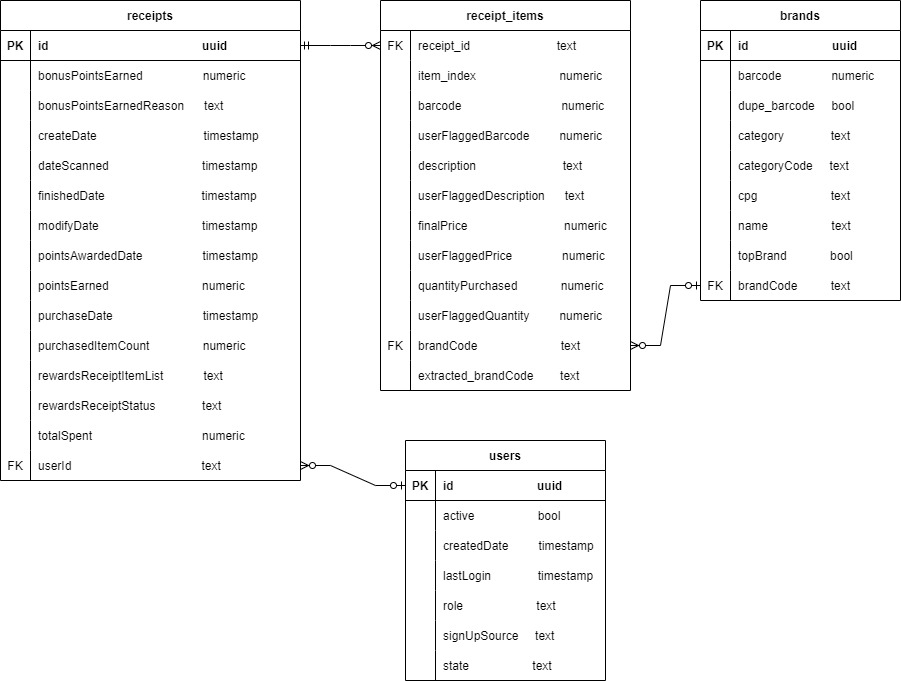